In [229]:
%pip install missingno
%pip install plotly.express

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

import missingno as msno
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)

### **Latar Belakang**

[Transjakarta, sebagai sistem *Bus Rapid Transit* (BRT) pertama di Indonesia yang diluncurkan sejak 2004](https://transjakarta.co.id/tentang/sejarah), hadir untuk menyediakan transportasi publik yang efisien, terjangkau, dan ramah lingkungan. Sebagai moda transportasi massal utama di Jakarta, Transjakarta memiliki peran strategis dalam mengurangi kemacetan dan mendukung mobilitas warga Jakarta.

Namun, dalam operasionalnya, Transjakarta [menghadapi tantangan penting](https://purejournal.ub.ac.id/index.php/pure/article/view/328/260) yang berdampak langsung pada **kualitas layanan dan kepuasan pelanggan**, seperti:

* Durasi perjalanan yang bervariasi dan tidak optimal
* Kepadatan tinggi di rute tertentu, terutama saat jam sibuk
* Ketimpangan distribusi armada antar waktu dan rute

Untuk menjaga kualitas layanan dan mendukung efisiensi operasional, diperlukan pemahaman yang lebih baik mengenai **pola perjalanan penumpang** agar perusahaan dapat merumuskan strategi alokasi armada yang tepat waktu, tepat rute, dan tepat sasaran.

---

### **Pernyataan Masalah**

Tim [Operasional dan Keselamatan Transjakarta](https://transjakarta.co.id/tentang/manajemen) membutuhkan insight berbasis data untuk menjawab pertanyaan berikut:

> **Bagaimana mengidentifikasi jam dan rute kritis berdasarkan data aktual penumpang untuk membantu pengambilan keputusan optimasi operasional dan penyesuaian jadwal layanan secara efisien?**

Analisis perjalanan berdasarkan rute dan waktu diharapkan dapat mengidentifikasi *area dan rentang waktu kritis* yang membutuhkan perhatian khusus, sehingga armada dapat dialokasikan dengan lebih efisien dan layanan publik semakin optimal.

### **Data Understanding**

In [231]:
tj_raw = pd.read_csv('D:/Bonifasius/Capstone Project (Data Analysis)/raw_dataset/Transjakarta.csv')
tj_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37900 entries, 0 to 37899
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transID           37900 non-null  object 
 1   payCardID         37900 non-null  int64  
 2   payCardBank       37900 non-null  object 
 3   payCardName       37900 non-null  object 
 4   payCardSex        37900 non-null  object 
 5   payCardBirthDate  37900 non-null  int64  
 6   corridorID        36643 non-null  object 
 7   corridorName      35970 non-null  object 
 8   direction         37900 non-null  float64
 9   tapInStops        36687 non-null  object 
 10  tapInStopsName    37900 non-null  object 
 11  tapInStopsLat     37900 non-null  float64
 12  tapInStopsLon     37900 non-null  float64
 13  stopStartSeq      37900 non-null  int64  
 14  tapInTime         37900 non-null  object 
 15  tapOutStops       35611 non-null  object 
 16  tapOutStopsName   36556 non-null  object

In [232]:
display(
    tj_raw['tapInTime'].dtype,
    tj_raw['tapOutTime'].dtype,
    pd.to_datetime(tj_raw['tapInTime']).agg(['min','max']),
    pd.to_datetime(tj_raw['tapOutTime']).agg(['min','max'])
)

dtype('O')

dtype('O')

min   2023-04-01 06:22:27
max   2023-04-30 21:55:41
Name: tapInTime, dtype: datetime64[ns]

min   2023-04-01 07:27:31
max   2023-04-30 23:23:18
Name: tapOutTime, dtype: datetime64[ns]

##### **Dataset Dictionary**

Dataset ini berisi informasi terkait *record* penumpang BRT *(Bus Rapid Transit)* Transjakarta selama 1 bulan, tepatnya di bulan April tahun 2023.

Ada 22 kolom di dalam dataset Transjakarta, yaitu:
- `transID`         : ID transaksi unik untuk setiap transaksi.

- `payCardID`       : ID pelanggan yang tertera di kartu pembayaran.

- `payCardBank`     : Nama bank penerbit kartu pelanggan.

- `payCardName`     : Nama pelanggan yang tercatat di kartu.

- `payCardSex`      : Jenis kelamin pelanggan yang tercatat di kartu.

- `payCardBirthDate`: Tahun kelahiran pelanggan.

- `corridorID`      : ID koridor/rute sebagai kunci pengelompokkan rute.

- `corridorName`    : Nama koridor/rute, termasuk titik mulai dan selesai.

- `direction`       : 0 untuk arah pergi, 1 untuk arah kembali.

- `tapInStops`      : ID halte tap-in (masuk) untuk mengidentifikasi nama halte.

- `tapInStopsName`  : Nama halte tap-in (masuk).

- `tapInStopsLat`   : Latitude halte tap-in.

- `tapInStopsLon`   : Longitude halte tap-in.

- `stopStartSeq`    : Urutan halte yang dikunjungi, terkait dengan arah perjalanan.

- `tapInTime`       : Waktu tap-in, tanggal dan jam.

- `tapOutStops`     : ID halte tap-out (keluar) untuk mengidentifikasi nama halte.

- `tapOutStopsName` : Nama halte tap-out (keluar).

- `tapOutStopsLat`  : Latitude halte tap-out.

- `tapOutStopsLon`  : Longitude halte tap-out.

- `stopEndSeq`      : Urutan halte yang dikunjungi, terkait dengan arah perjalanan.

- `tapOutTime`      : Waktu tap-out, tanggal dan jam.

- `payAmount`       : Jumlah pembayaran yang dilakukan pelanggan, ada yang gratis, ada yang berbayar.

Berikut 5 baris awal dari dataset Transjakarta.

In [233]:
tj_raw.head()

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
0,EIIW227B8L34VB,180062659848800,emoney,Bajragin Usada,M,2008,5,Matraman Baru - Ancol,1.0,P00142,Pal Putih,-6.184631,106.84402,7,2023-04-03 05:21:44,P00253,Tegalan,-6.203101,106.85715,12.0,2023-04-03 06:00:53,3500.0
1,LGXO740D2N47GZ,4885331907664776,dki,Gandi Widodo,F,1997,6C,Stasiun Tebet - Karet via ...,0.0,B01963P,Kemenkes 2,-6.228700,106.83302,13,2023-04-03 05:42:44,B03307P,Sampoerna Strategic,-6.217152,106.81892,21.0,2023-04-03 06:40:01,3500.0
2,DJWR385V2U57TO,4996225095064169,dki,Emong Wastuti,F,1992,R1A,Pantai Maju - Kota,0.0,B00499P,Gg. Kunir II,-6.133132,106.81435,38,2023-04-03 05:59:06,B04962P,Simpang Kunir Kemukus,-6.133731,106.81475,39.0,2023-04-03 06:50:55,3500.0
3,JTUZ800U7C86EH,639099174703,flazz,Surya Wacana,F,1978,11D,Pulo Gebang - Pulo Gadung ...,0.0,B05587P,Taman Elok 1,-6.195743,106.93526,23,2023-04-03 05:44:51,B03090P,Raya Penggilingan,-6.183068,106.93194,29.0,2023-04-03 06:28:16,3500.0
4,VMLO535V7F95NJ,570928206772,flazz,Embuh Mardhiyah,M,1982,12,Tanjung Priok - Pluit,0.0,P00239,Sunter Boulevard Barat,-6.149650,106.88900,5,2023-04-03 06:17:35,P00098,Kali Besar Barat,-6.135355,106.81143,15.0,2023-04-03 06:57:03,3500.0


##### **Inspeksi Dataset**

Mari kita mulai dengan melakukan inspeksi terhadap dataset Transjakarta. Selain agar dapat lebih mengetahui isi nilai dari setiap kolomnya, kita juga berupaya untuk menemukan anomali dan cara untuk menanganinya lebih lanjut di tahapan _data cleaning._ Setiap tindakan yang dilakukan, akan disertai dengan justifikasi langkah yang diambil, baik secara _domain knowledge_ maupun secara statistik.

In [234]:
print(f'Bentuk dataset: {tj_raw.shape[0]} baris & {tj_raw.shape[1]} kolom.\n')

display(tj_raw.iloc[:,3:].describe(), tj_raw.describe(include='object'))

Bentuk dataset: 37900 baris & 22 kolom.



,payCardBirthDate,direction,tapInStopsLat,tapInStopsLon,stopStartSeq,tapOutStopsLat,tapOutStopsLon,stopEndSeq,payAmount
count,37900.000000,37900.000000,37900.000000,37900.000000,37900.000000,36556.000000,36556.000000,36556.000000,36893.000000
mean,1990.089314,0.500633,-6.214838,106.841554,13.572480,-6.214651,106.841233,21.219909,2699.712683
std,13.051482,0.500006,0.057911,0.060369,12.237623,0.059022,0.060999,13.800689,4212.225592
min,1946.000000,0.000000,-6.394973,106.614730,0.000000,-6.394973,106.614730,1.000000,0.000000
25%,1982.000000,0.000000,-6.245863,106.803470,4.000000,-6.247225,106.801750,11.000000,0.000000
50%,1990.000000,1.000000,-6.214587,106.834830,10.000000,-6.214718,106.834580,18.000000,3500.000000
75%,2001.000000,1.000000,-6.175528,106.882270,19.000000,-6.174736,106.883030,29.000000,3500.000000
max,2012.000000,1.000000,-6.089429,107.023950,68.000000,-6.091746,107.023660,77.000000,20000.000000


,transID,payCardBank,payCardName,payCardSex,corridorID,corridorName,tapInStops,tapInStopsName,tapInTime,tapOutStops,tapOutStopsName,tapOutTime
count,37900,37900,37900,37900,36643,35970,36687,37900,37900,35611,36556,36556
unique,37900,6,1993,2,221,216,2570,2602,37079,2230,2248,35908
top,EIIW227B8L34VB,dki,Suci Wacana,F,1T,Cibubur - Balai Kota,P00170,Penjaringan,2023-04-06 17:35:40,P00016,BKN,2023-04-24 06:53:50
freq,1,18743,80,20157,400,391,236,243,3,306,316,3


Tampaknya ada *records* yang harga tiketnya `0 atau gratis`. Mari kita investigasi lebih lanjut.

In [235]:
display(
    tj_raw[tj_raw['payAmount'] == 0].shape,
    tj_raw[tj_raw['payAmount'] == 0].sample(3)
)

(16648, 22)

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
7624,WHLZ919T9S86ST,4345294247705168,dki,"Dasa Hastuti, S.Psi",M,1984,JAK.115,Term. Tj. Priok - Pegangsa...,0.0,NaN,Sbr. Jln. Komplek Yuka,-6.126030,106.91702,18,2023-04-19 17:08:55,B06604P,Simpang Jln. Pegangsaan Dua,-6.182230,106.91850,40.0,2023-04-19 18:56:52,0.0
29445,TFFL777L9P85BW,4247047725165183,dki,Danang Santoso,F,2006,JAK.06,Kampung Rambutan - Pondok ...,0.0,B05387P,SMPN 6 Bekasi,-6.282590,106.91272,2,2023-04-26 09:50:45,B01539P,Jln. Rawa Segaran,-6.306765,106.89190,47.0,2023-04-26 10:25:03,0.0
34818,WPNL932E1G82FI,3540357155140234,dki,R. Cornelia Saputra,M,1985,2E,Rusun Rawa Bebek - Kodamar,0.0,B00822P,Jagal 1,-6.190849,106.93465,17,2023-04-13 06:06:55,B00070P,ASMI 2,-6.172158,106.88894,29.0,2023-04-13 07:32:52,0.0


Mengacu kepada kolom `corridorID`, kita sekarang mengetahui dan juga dapat kita validasi dengan *domain knowledge* terkait layanan Transjakarta, bahwa dataset ini juga terdiri dari *records* layanan [Jaklingko](https://money.kompas.com/read/2023/03/13/140000226/naik-angkot-jaklingko-masih-gratis-), serta layanan gratis [TJ Card](https://smartcity.jakarta.go.id/id/blog/gratis-naik-transjakarta-untuk-kamu-dengan-15-kriteria-ini/) dengan kriteria penumpang tertentu.

Selanjutnya, kita akan coba memahami durasi perjalanan penumpang Transjakarta. Pertama-tama, mari kita rubah tipe data kolom `tapInTime` dan `tapOutTime` dari `object` menjadi `datetime`. Lalu kita akan cek apakah ada anomali dari kedua kolom tersebut.

In [236]:
tj_raw['tapInTime'] = pd.to_datetime(tj_raw['tapInTime'], format='%Y-%m-%d %H:%M:%S')
tj_raw['tapOutTime'] = pd.to_datetime(tj_raw['tapOutTime'], format='%Y-%m-%d %H:%M:%S')

tj_raw[['tapInTime','tapOutTime']].dtypes

tapInTime     datetime64[ns]
tapOutTime    datetime64[ns]
dtype: object

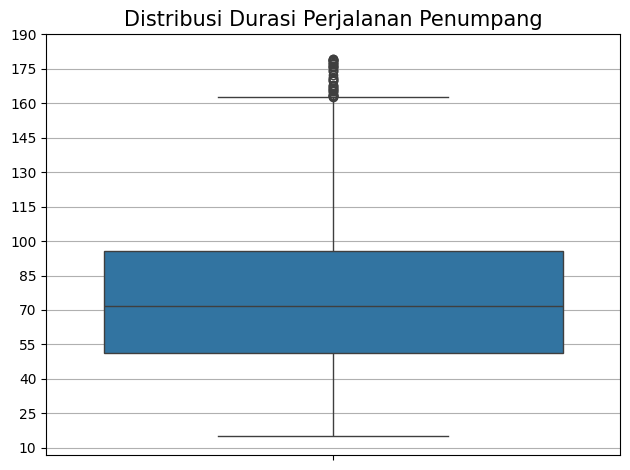

In [237]:
anomali_waktu = round((tj_raw['tapOutTime'] - tj_raw['tapInTime']).dt.total_seconds() / 60, 2)
sns.boxplot(anomali_waktu)
plt.yticks(range(10,195,15))
plt.grid(axis='y')
plt.title('Distribusi Durasi Perjalanan Penumpang', size=15)

plt.tight_layout();

Berdasarkan interval waktu perjalanan penumpang, terdapat `44 rows` yang memiliki anomali durasi perjalanan tidak wajar. Kita akan dokumentasikan terlebih dahulu dengan cara menyimpan `index` dari anomali ini. Kita investigasi serta tindak lanjuti pada tahapan *data cleaning* karena durasi perjalanan penumpang menjadi salah satu bagian penting dalam proses analisis yang akan kita lakukan nanti.

In [238]:
index_anomali_waktu = anomali_waktu[anomali_waktu > 160].index

display(
    len(anomali_waktu[index_anomali_waktu]),
    index_anomali_waktu
)

44

Index([37605, 37608, 37614, 37615, 37616, 37619, 37623, 37632, 37633, 37651,
       37661, 37663, 37665, 37672, 37674, 37681, 37692, 37702, 37710, 37719,
       37720, 37742, 37744, 37752, 37753, 37758, 37761, 37784, 37806, 37822,
       37824, 37831, 37837, 37851, 37859, 37861, 37867, 37871, 37874, 37875,
       37878, 37883, 37891, 37897],
      dtype='int64')

Selanjutnya mari kita cek untuk memastikan apakah terdapat duplikat data atau tidak pada dataset Transjakarta.

In [239]:
# tj_raw[tj_raw['payCardID'].duplicated()].head() # 4885331907664776, dki, Gandi Widodo, Sawo Kecik Raya, 2023-04-03 17:35:45, 2023-04-03 19:00:15

tj_raw[tj_raw['payCardID'].duplicated(keep=False)].head()

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
0,EIIW227B8L34VB,180062659848800,emoney,Bajragin Usada,M,2008,5,Matraman Baru - Ancol,1.0,P00142,Pal Putih,-6.184631,106.84402,7,2023-04-03 05:21:44,P00253,Tegalan,-6.203101,106.85715,12.0,2023-04-03 06:00:53,3500.0
1,LGXO740D2N47GZ,4885331907664776,dki,Gandi Widodo,F,1997,6C,Stasiun Tebet - Karet via ...,0.0,B01963P,Kemenkes 2,-6.228700,106.83302,13,2023-04-03 05:42:44,B03307P,Sampoerna Strategic,-6.217152,106.81892,21.0,2023-04-03 06:40:01,3500.0
2,DJWR385V2U57TO,4996225095064169,dki,Emong Wastuti,F,1992,R1A,Pantai Maju - Kota,0.0,B00499P,Gg. Kunir II,-6.133132,106.81435,38,2023-04-03 05:59:06,B04962P,Simpang Kunir Kemukus,-6.133731,106.81475,39.0,2023-04-03 06:50:55,3500.0
3,JTUZ800U7C86EH,639099174703,flazz,Surya Wacana,F,1978,11D,Pulo Gebang - Pulo Gadung ...,0.0,B05587P,Taman Elok 1,-6.195743,106.93526,23,2023-04-03 05:44:51,B03090P,Raya Penggilingan,-6.183068,106.93194,29.0,2023-04-03 06:28:16,3500.0
4,VMLO535V7F95NJ,570928206772,flazz,Embuh Mardhiyah,M,1982,12,Tanjung Priok - Pluit,0.0,P00239,Sunter Boulevard Barat,-6.149650,106.88900,5,2023-04-03 06:17:35,P00098,Kali Besar Barat,-6.135355,106.81143,15.0,2023-04-03 06:57:03,3500.0


In [240]:
display(
    tj_raw['transID'].duplicated().sum(), 
    tj_raw['payCardID'].duplicated().sum(), 
    tj_raw['payCardName'].duplicated().sum()
)

np.int64(0)

np.int64(35900)

np.int64(35907)

Dari sini kita dapat memahami bahwa dataset Transjakarta ini tidak terdapat duplikat, namun terdapat transaksi berulang dari *loyal customer* atau penumpang yang secara rutin memang menggunakan layanan Transjakarta untuk opsi transportasi utama mereka. Oleh karena itu, temuan ini akan kita biarkan karena *records* tersebut merupakan data yang valid.

In [241]:
pd.set_option('display.max_colwidth', 30)
unique_items = []

for col in tj_raw.columns :
    unique_items.append( [col, tj_raw[col].nunique(), tj_raw[col].unique()])

raw_desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=unique_items)
raw_desc

,Column Name,Number of Unique,Unique Sample
0,transID,37900,"[EIIW227B8L34VB, LGXO740D2..."
1,payCardID,2000,"[180062659848800, 48853319..."
2,payCardBank,6,"[emoney, dki, flazz, onlin..."
3,payCardName,1993,"[Bajragin Usada, Gandi Wid..."
4,payCardSex,2,"[M, F]"
5,payCardBirthDate,67,"[2008, 1997, 1992, 1978, 1..."
6,corridorID,221,"[5, 6C, R1A, 11D, 12, 1T, ..."
7,corridorName,216,"[Matraman Baru - Ancol, St..."
8,direction,2,"[1.0, 0.0]"
9,tapInStops,2570,"[P00142, B01963P, B00499P,..."


Dari hasil inspeksi yang telah kita lakukan, dapat disimpulkan bahwa:

- Dataset Transjakarta memiliki 37.900 baris & 22 kolom
- beberapa kolom, seperti: `corridorID`, `corridorName`, `tapInStops`, `tapOutStops`, `tapOutStopsName`, `tapOutStopsLat`, `tapOutStopsLon`, `stopEndSeq`, `tapOutTime`, dan `payAmount` memiliki data kosong. Data kosong pada kolom-kolom tersebut diwakili dengan data `NaN`.
- Kolom `transID` memiliki 37900 nilai unik yang menunjukkan tidak terdapat transaksi duplikat pada dataset ini. Tetapi berdasarkan kolom `payCardID	` dan `payCardName`, terdapat catatan transaksi dari penumpang yang sama yang menggunakan layanan Transjakarta secara rutin.
- Kolom `payCardID`, `tapInStops`, dan `tapOutStops` berisikan ID unik untuk setiap kartu pembayaran, halde tap-in/tap-out penumpang, yang sudah terwakilkan keterangannya pada beberapa kolom lain. Oleh karena itu kolom `transID`, `tapInStops`, dan `tapOutStops` kurang relevan untuk analisis dan dapat kita _drop_ saja.
- Terdapat anomali di interval durasi perjalanan penumpang, mempertimbangkan untuk membuat kolom baru dari agregasi kolom `tapInTime` dan `tapOutTime` yang akan berisi durasi perjalanan dalam satuan menit agar dapat ditangani lebih lanjut.
- Beberapa kolom seperti: `tapOutStopsName, tapOutStopsLat, tapOutStopsLon, stopEndSeq, tapOutTime` mengandung jumlah `NaN` yang sama. Kita dapat asumsikan diawal bahwa setiap _missing value_ dari 5 kolom tersebut berada di _row_ yang sama. Kita akan cek dan pastikan lebih lanjut.
- Kolom `payCardBirthDate` dapat kita manfaatkan untuk mencari umur dari setiap penumpang (`2023 - payCardBirthDate`). Kita sesuaikan dimensi waktu karena dataset ini hanya berisikan *records* penumpang Transjakarta di bulan April tahun 2023.

### **Data Cleaning**

Kita *assign* dataset Transjakarta ke variabel baru, agar perubahan yang kita lakukan lebih leluasa dan efisien. Misalnya, jika sewaktu-waktu kita melakukan perubahan yang `berakibat fatal` ke proses analisis, kita dapat kembali ke bentuk dataset awal dengan mudah.

In [242]:
df_tj = tj_raw.copy()

##### **Missing Value Check**

In [243]:
df_missing = pd.DataFrame(df_tj.isna().sum()).rename(columns={0:'missingCount'})
df_missing['missingPercentage'] = round((df_missing['missingCount'] / len(df_tj)), 4) * 100
df_missing

,missingCount,missingPercentage
transID,0,0.00
payCardID,0,0.00
payCardBank,0,0.00
payCardName,0,0.00
payCardSex,0,0.00
payCardBirthDate,0,0.00
corridorID,1257,3.32
corridorName,1930,5.09
direction,0,0.00
tapInStops,1213,3.20


##### **Missing Value Distribution Check**

<Axes: >

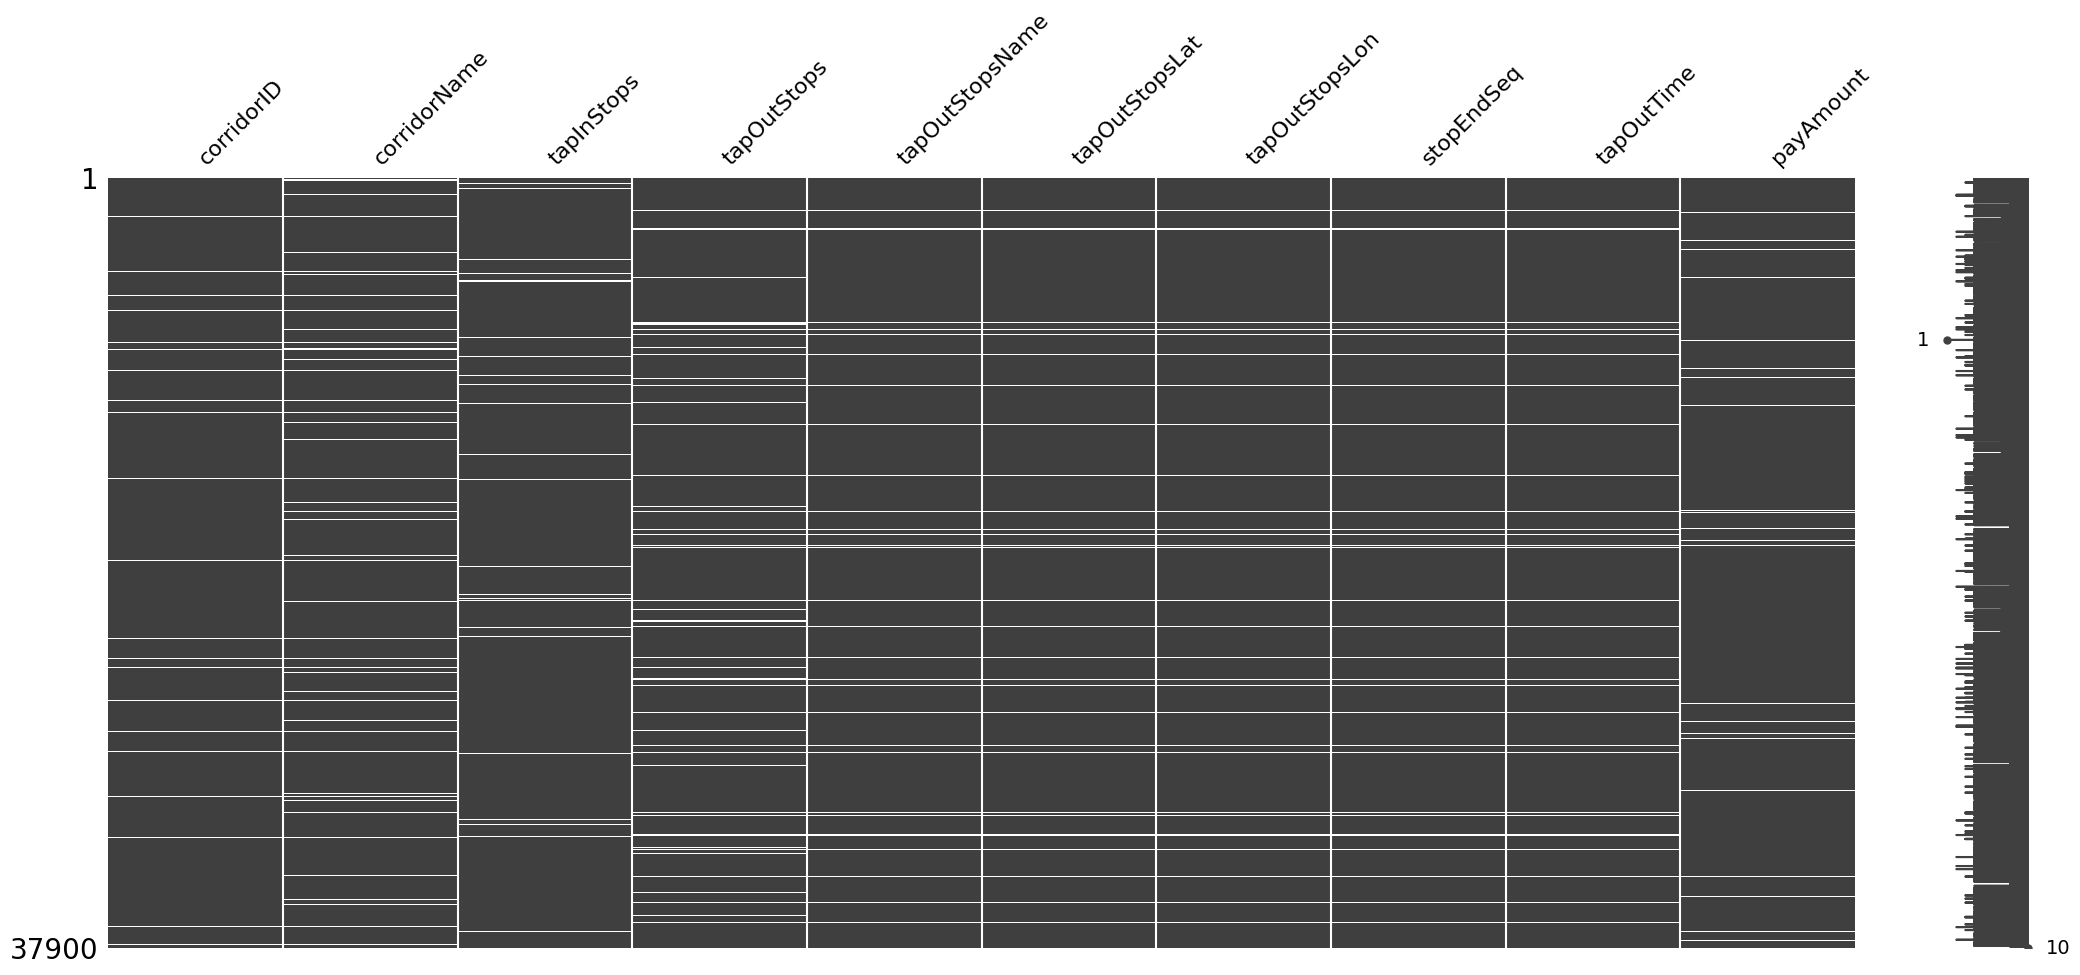

In [244]:
msno.matrix(df_tj[
                  ['corridorID', 'corridorName',
                  'tapInStops',
                  'tapOutStops', 'tapOutStopsName',
                  'tapOutStopsLat', 'tapOutStopsLon',
                  'stopEndSeq', 'tapOutTime',
                  'payAmount']
                  ]
            )

<Axes: >

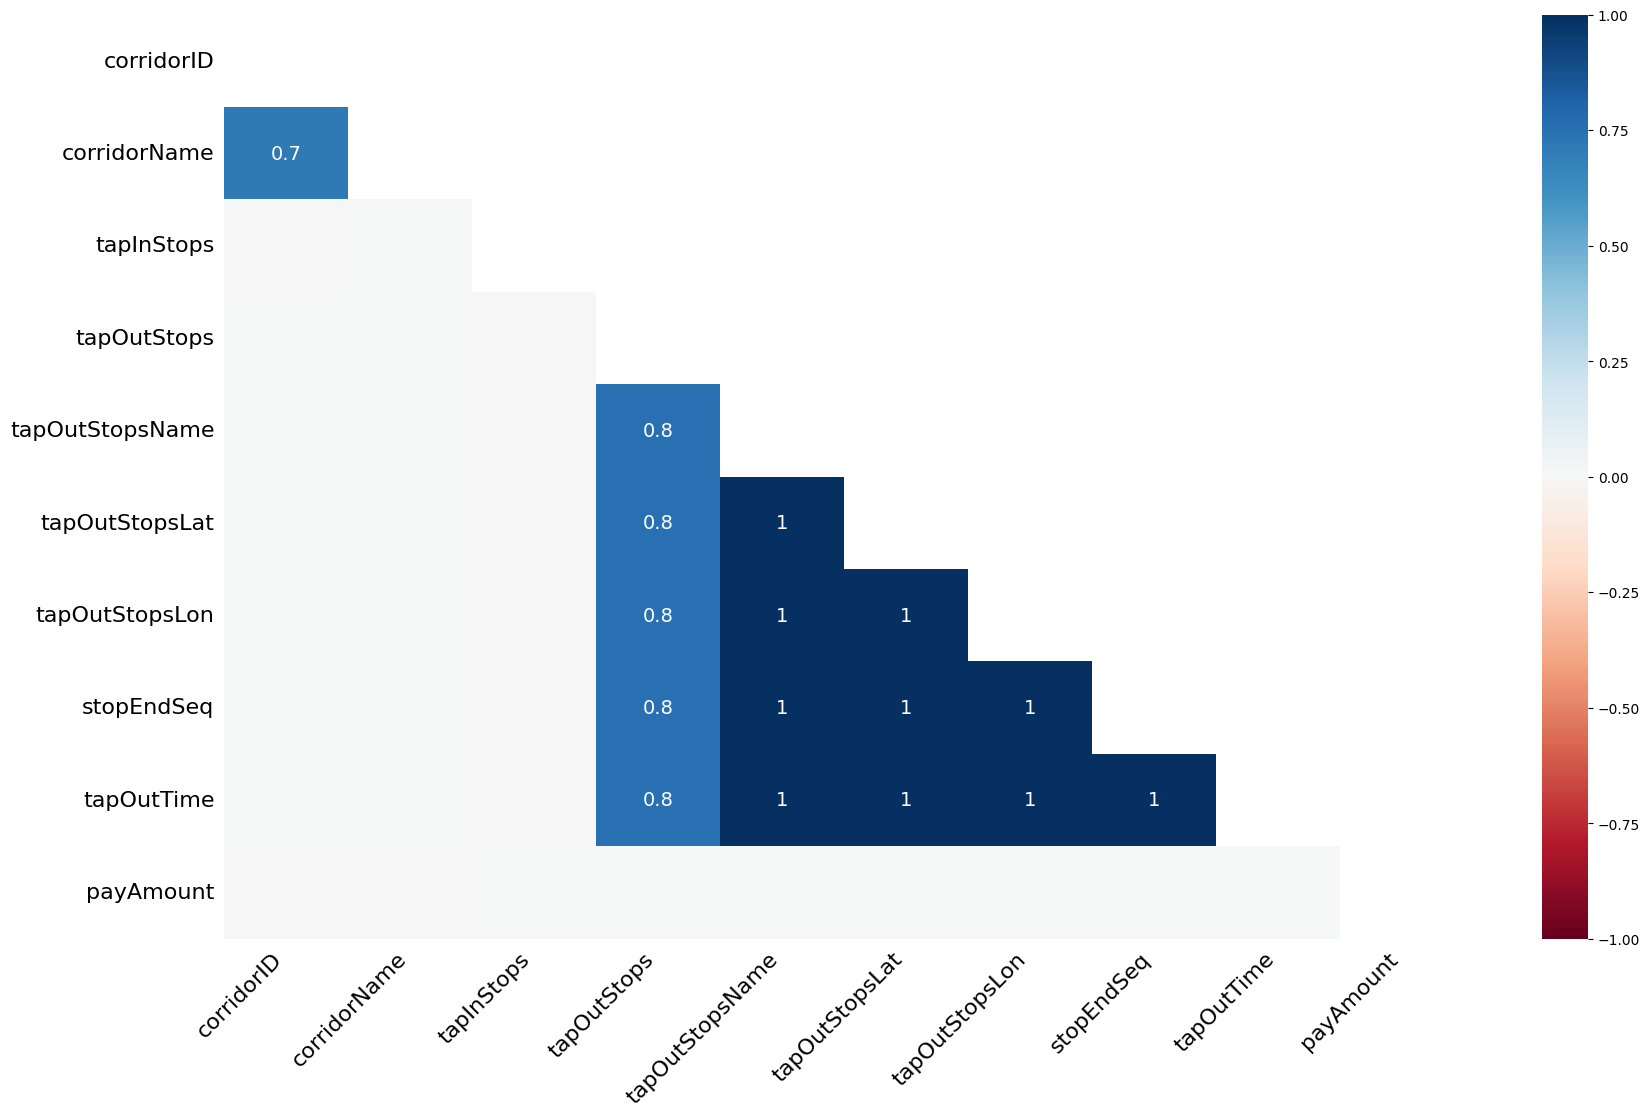

In [245]:
msno.heatmap(df_tj)

Secara garis besar:  
* Persentase *missing value* dari dataset Transjakarta hanya terdiri _kurang dari 10%_ dari setiap kolomnya. Dengan kolom `tapOutStops` yang memiliki _missing value_ terbanyak dengan persentase sebesar 6.04%
* *missing value* di kolom : `tapOutStopsName, tapOutStopsLat, tapOutStopsLon`, dan kolom `stopEndSeq` memiliki *missing values* yang saling berkaitan. Dengan kata lain, *missing value* dari berbagai kolom ini berada di row yang sama.

Ada beberapa cara untuk menangani *missing value*:

1. Jika persentase missing < 5% : `delete row`
1. 5-20% : `simple imputation` (mean, median, modus, constant)
1. 20-50% : `advanced immputer` (KKN, iterative imputer)
1. Jika persentase missing > 50% : `delete column`

* Kolom `corridorID`, `tapInStops`, dan `tapOutStops` dapat kita biarkan saja karena bukan termasuk bagian yang dapat kita analisis (*column to drop*)
* Untuk `tapOutStopsName, tapOutStopsLat, tapOutStopsLon`, dan kolom `stopEndSeq`, tidak bisa langsung kita `dropna` karena *missing value* dari kolom-kolom tersebut saling berkaitan. Oleh karena itu, kita perlu melakukan imputasi untuk mengisi *missing value*.
* *Missing value* di kolom `payAmount` juga masih dapat kita isi dengan *domain knowledge* tarif Transjakarta yaitu dengan harga *flat* 3500 untuk setiap kali *tap in*. Dimana kita asumsikan, seharusnya *median* dan *mode* dari kolom `payAmount` juga merupakan 3500.

##### **Handle Missing Value**

Kita akan mulai mencoba imputasi ke kolom kategori yang terdapat *missing values* yaitu: `corridorName` dan `tapOutStopsName`. Mari kita mulai dari kolom `tapOutStopsName` karena kolom ini akan menjadi acuan saat kita imputasi kolom `corridorName` selanjutnya.

Untuk cara imputasi yang kita gunakan adalah mencoba mengisi *missing values* dengan menjadikan kolom lain sebagai acuan `SimpleImputer (most_frequent)`.

Imputasi akan dilakukan dengan data yang sudah ada, berdasarkan kolom-kolom yang saling berkorelasi, ataupun dengan *domain knowledge*. Tujuan imputasi ini agar persentase *missing values* pada dataset Transjakarta tidak ada yang melebihi 5%. Terakhir, dari sisa-sisa dari *missing values* nantinya dapat kita *drop*.

> `tapOutStopsName`

Mari kita isi *missing values* di kolom `tapOutStopsName` dengan menjadikan kolom `tapInStopsName` sebagai kolom acuannya, dengan strategi `most_frequent` atau modus sebagai imputasi karena tipe datanya berupa kategorikal.

In [246]:
mode_imputer = SimpleImputer(strategy='most_frequent')

df_tj['tapOutStopsName'] = df_tj.groupby('tapInStopsName')['tapOutStopsName'] \
    .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() if not x.mode().empty else x)

> `corridorName`

Selanjutnya kita coba isi *missing values* di kolom `corridorName` dengan menjadikan kolom `tapInStopsName` dan `tapOutStopsName` sebagai kolom acuannya.

In [247]:
display(
    tj_raw['corridorName'].isna().sum(),
    df_tj.groupby(['tapInStopsName','tapOutStopsName'])['corridorName'] \
    .transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x).isna().sum())

print(1468 / 37900 * 100)

np.int64(1930)

np.int64(160)

3.8733509234828496


In [248]:
df_tj['corridorName'] = df_tj.groupby(['tapInStopsName','tapOutStopsName'])['corridorName'] \
    .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() if not x.mode().empty else x)

In [249]:
display(
    tj_raw['corridorName'].isna().sum(),
    df_tj['corridorName'].isna().sum()
)

np.int64(1930)

np.int64(160)

Sekarang kita coba cek hasilnya apakah masuk akal atau tidak berdasarkan *domain knowledge* kita terhadap daerah dan ruas jalan di kota Jakarta.

In [250]:
display(
    # tj_raw[(tj_raw['corridorName'].isna()) & (tj_raw['tapOutStopsName'].isna())][['corridorName','direction','tapInStopsName','tapOutStopsName']].sample(5),
    tj_raw.iloc[[24132, 19342, 876, 14941, 23084]][['corridorName','direction','tapInStopsName','tapOutStopsName']],
    df_tj.iloc[[24132, 19342, 876, 14941, 23084]][['corridorName','direction','tapInStopsName','tapOutStopsName']])

,corridorName,direction,tapInStopsName,tapOutStopsName
24132,NaN,0.0,Velodrome,NaN
19342,NaN,0.0,Kejaksaan Agung,NaN
876,NaN,1.0,Jln. Prima,NaN
14941,NaN,1.0,Gg. Sawo Joglo,NaN
23084,NaN,0.0,TU Gas,NaN


,corridorName,direction,tapInStopsName,tapOutStopsName
24132,Pulo Gadung 2 - Dukuh Atas 2,0.0,Velodrome,Dukuh Atas 2
19342,Cibubur Junction - Blok M,0.0,Kejaksaan Agung,Blok M Jalur 4
876,Rawa Buaya - Rawa Kompeni,1.0,Jln. Prima,Sbr. SMAN 95
14941,Joglo - Blok M,1.0,Gg. Sawo Joglo,Simpang Kramat II
23084,TU Gas - Bundaran Senayan,0.0,TU Gas,Polda Metro Jaya


In [251]:
col_to_validate = ['corridorName','direction','stopStartSeq','tapInTime','tapOutStopsLat','tapOutStopsLon','stopEndSeq','tapOutTime','payAmount']

> `tapOutTime`

Sebelumnya kita sudah *casting* tipe data dari kolom `tapInTime` dan `tapOutTime`. Kita akan coba cari nilai `mean` dan `median` dari durasi perjalanan penumpang Transjakarta kemudian kita terapkan `Simple Imputer` kolom `tapOutTime`.

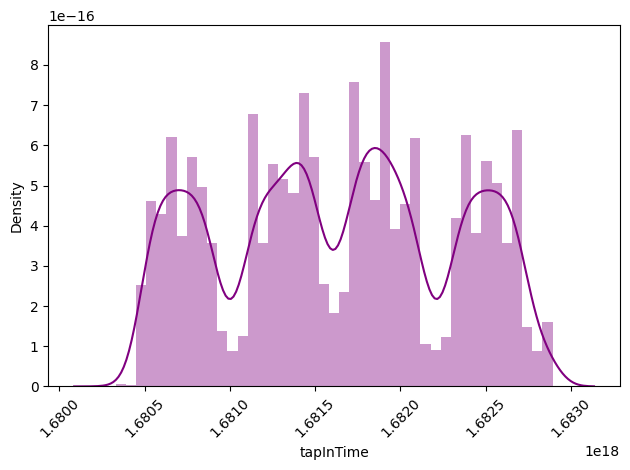

In [252]:
sns.distplot(df_tj['tapInTime'].astype('datetime64[ns]'), kde=True, color='purple')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [253]:
display(
    round((df_tj['tapOutTime'] - df_tj['tapInTime']).dt.total_seconds().median() / 60, 2),
    round((df_tj['tapOutTime'] - df_tj['tapInTime']).dt.total_seconds().mean() / 60, 2)
)

np.float64(71.83)

np.float64(72.13)

Meskipun perbedaannya sangat kecil antara `mean` dan `median` dari durasi perjalanan penumpang Transjakarta, kita akan gunakan `median` karena dapat lebih menyesuaikan dengan `bentuk persebaran datanya`.

In [254]:
median_dur = round((df_tj['tapOutTime'] - df_tj['tapInTime']).dt.total_seconds().median() / 60, 2)

print(f'Rata-rata durasi perjalanan penumpang: {median_dur} menit')

Rata-rata durasi perjalanan penumpang: 71.83 menit


In [255]:
df_tj['tapOutTime'] = df_tj['tapOutTime'].fillna(df_tj['tapInTime'].apply(lambda x: x + pd.Timedelta(minutes=int(median_dur))))

Sekarang kita coba cek hasilnya.

In [256]:
display(tj_raw[tj_raw['tapOutTime'].isna()][col_to_validate].head(), \
        df_tj.iloc[[6,30,70,130,192]][col_to_validate])

,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
6,Kalibata - Kuningan,0.0,25,2023-04-03 06:58:21,NaN,NaN,NaN,NaT,0.0
30,Pasar Minggu - Jagakarsa,1.0,19,2023-04-03 06:14:02,NaN,NaN,NaN,NaT,0.0
70,Cibubur - Balai Kota,0.0,7,2023-04-03 05:57:55,NaN,NaN,NaN,NaT,20000.0
130,Kampung Rambutan - Tanjung...,0.0,7,2023-04-03 05:40:04,NaN,NaN,NaN,NaT,3500.0
192,Kalideres - Gelora Bung Karno,0.0,11,2023-04-03 06:15:53,NaN,NaN,NaN,NaT,3500.0


,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
6,Kalibata - Kuningan,0.0,25,2023-04-03 06:58:21,NaN,NaN,NaN,2023-04-03 08:09:21,0.0
30,Pasar Minggu - Jagakarsa,1.0,19,2023-04-03 06:14:02,NaN,NaN,NaN,2023-04-03 07:25:02,0.0
70,Cibubur - Balai Kota,0.0,7,2023-04-03 05:57:55,NaN,NaN,NaN,2023-04-03 07:08:55,20000.0
130,Kampung Rambutan - Tanjung...,0.0,7,2023-04-03 05:40:04,NaN,NaN,NaN,2023-04-03 06:51:04,3500.0
192,Kalideres - Gelora Bung Karno,0.0,11,2023-04-03 06:15:53,NaN,NaN,NaN,2023-04-03 07:26:53,3500.0


> `payAmount`

Sekarang kita coba mengisi *missing values* di kolom `payAmount` yang bertipe numerik. Mari kita awali dengan melakukan *plot* agar dapat mengetahui bentuk distribusi datanya.

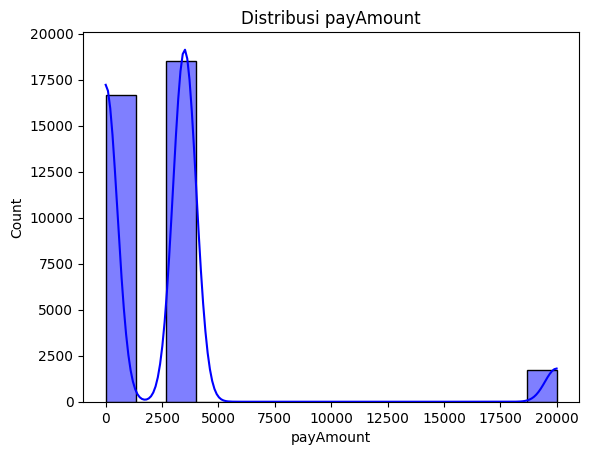

In [257]:
sns.histplot(df_tj['payAmount'], kde=True, bins=15, color='b')
plt.title('Distribusi payAmount')

plt.show()

Terlihat bahwa distribusi data pada kolom `payAmount` tidak berbentuk normal, melainkan terdiri dari beberapa nilai tetap yang berulang, yaitu Rp 0, Rp 3.500, dan Rp 20.000. Nilai Rp 3.500 merupakan tarif reguler Transjakarta, sedangkan Rp 0 kemungkinan berasal dari pengguna program subsidi (seperti ASN, atau Jaklingko).

In [258]:
display(
    df_tj[df_tj['payCardSex'] == 'M']['payAmount'].value_counts(),
    df_tj[df_tj['payCardSex'] == 'F']['payAmount'].value_counts()
)

payAmount
3500.0     8820
0.0        7624
20000.0     803
Name: count, dtype: int64

payAmount
3500.0     9683
0.0        9024
20000.0     939
Name: count, dtype: int64

Selain itu, terlihat bahwa terdapat anomali di kolom `payAmount` dengan nilai Rp 20.000, namun berdasarkan *domain knowledge*, Transjakarta memang menyediakan layanan bus premium dengan harga Rp 20.000 yang bernama [Royaltrans dan telah beroperasi sejak tahun 2017.](https://megapolitan.kompas.com/read/2023/08/27/01000061/tarif-royaltrans-dan-rutenya-2023)

Berdasarkan *domain knowledge* tersebut, kita ambil keputusan untuk **tidak merubah atau mengeliminasi** *outliers* di kolom `payAmount` karena kita justru bisa mendapatkan **insight** dengan cara menganalisa dan membandingkan 3 moda layanan Transjakarta untuk menjawab permasalahan yang telah kita rumuskan sebelumnya.

Selanjutnya, mita lanjutkan proses penanganan *missing values* untuk kolom `payAmount`.

In [259]:
df_tj[['payCardName','payCardBirthDate']].nunique()

payCardName         1993
payCardBirthDate      67
dtype: int64

Dengan distribusi yang tidak normal, kita kesampingkan imputasi berdasarkan `mean`, dan dengan kolom `payAmount` yang bertipe numerik, imputasi dengan `median` menjadi opsi yang lebih cocok untuk kita terapkan.

Kita akan lakukan `Simple Imputer` (`median`) berdasarkan kolom `payCardBirthDate` para penumpang Transjakarta. Karena terlihat dari 37900 *records*, tampaknya berasal dari `1993` orang yang memang mengandalkan layanan Transjakarta sebagai opsi utama transportasi mereka.

In [260]:
display(df_tj['payAmount'].isna().sum())
print(f'{round(df_tj['payAmount'].isna().sum() / len(df_tj) * 100, 2)}%')

np.int64(1007)

2.66%


In [261]:
display(df_tj['payAmount'].mode(), df_tj['payAmount'].median())

0    3500.0
Name: payAmount, dtype: float64

np.float64(3500.0)

Asumsi awal terkait kolom `payAmount` yang berlandaskan *domain knowledge* terhadap harga tiket layanan Transjakarta tampaknya valid bahwa nilai `mode` dan `median`-nya sama-sama bernilai 3500.

In [262]:
median_imputer = SimpleImputer(strategy='median')

In [263]:
df_tj['payAmount'] = df_tj.groupby('payCardBirthDate')['payAmount'] \
    .transform(lambda x: median_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() if not x.mode().empty else x)

Sekarang kita bandingkan dan cek hasilnya

In [264]:
tj_raw[tj_raw['payAmount'].isna()].sample(5).index

Index([26251, 18751, 37674, 4069, 10597], dtype='int64')

In [265]:
display( # 1669, 10876, 36708, 35887
    tj_raw.loc[[1669, 10876, 36708, 35887]][col_to_validate],
    df_tj.loc[[1669, 10876, 36708, 35887]][col_to_validate]
)

,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
1669,BKN - Blok M,0.0,1,2023-04-05 17:59:10,-6.243369,106.80188,24.0,2023-04-05 19:34:26,NaN
10876,Stasiun Tebet - Kampung Me...,0.0,1,2023-04-27 05:35:51,-6.220486,106.86825,11.0,2023-04-27 06:26:50,NaN
36708,BKN - Blok M,0.0,14,2023-04-17 18:13:35,-6.240036,106.82842,19.0,2023-04-17 19:18:09,NaN
35887,Stasiun Tebet - Rusun Kare...,0.0,10,2023-04-15 20:26:06,-6.221933,106.82093,12.0,2023-04-15 21:49:30,NaN


,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
1669,BKN - Blok M,0.0,1,2023-04-05 17:59:10,-6.243369,106.80188,24.0,2023-04-05 19:34:26,3500.0
10876,Stasiun Tebet - Kampung Me...,0.0,1,2023-04-27 05:35:51,-6.220486,106.86825,11.0,2023-04-27 06:26:50,3500.0
36708,BKN - Blok M,0.0,14,2023-04-17 18:13:35,-6.240036,106.82842,19.0,2023-04-17 19:18:09,3500.0
35887,Stasiun Tebet - Rusun Kare...,0.0,10,2023-04-15 20:26:06,-6.221933,106.82093,12.0,2023-04-15 21:49:30,0.0


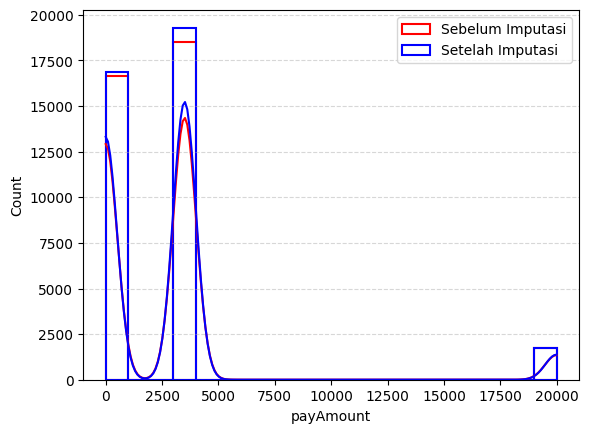

In [266]:
sns.histplot(tj_raw['payAmount'], kde=True, color='red', bins=20, fill=False, label='Sebelum Imputasi')
sns.histplot(df_tj['payAmount'], kde=True, color='blue', bins=20, fill=False, label='Setelah Imputasi')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

Hasil imputasi pada kolom `payAmount` tidak mengakibatkan perubahan fatal pada persebaran datanya, dan perbedaan yang ada masih bisa kita toleransi.

#### **DF Cleaned**

In [267]:
display(df_tj.columns, df_tj.isna().sum())

Index(['transID', 'payCardID', 'payCardBank', 'payCardName', 'payCardSex',
       'payCardBirthDate', 'corridorID', 'corridorName', 'direction',
       'tapInStops', 'tapInStopsName', 'tapInStopsLat', 'tapInStopsLon',
       'stopStartSeq', 'tapInTime', 'tapOutStops', 'tapOutStopsName',
       'tapOutStopsLat', 'tapOutStopsLon', 'stopEndSeq', 'tapOutTime',
       'payAmount'],
      dtype='object')

transID                0
payCardID              0
payCardBank            0
payCardName            0
payCardSex             0
payCardBirthDate       0
corridorID          1257
corridorName         160
direction              0
tapInStops          1213
tapInStopsName         0
tapInStopsLat          0
tapInStopsLon          0
stopStartSeq           0
tapInTime              0
tapOutStops         2289
tapOutStopsName       36
tapOutStopsLat      1344
tapOutStopsLon      1344
stopEndSeq          1344
tapOutTime             0
payAmount              0
dtype: int64

In [268]:
df_tj.loc[:, df_tj.isna().sum() > 0].columns

Index(['corridorID', 'corridorName', 'tapInStops', 'tapOutStops',
       'tapOutStopsName', 'tapOutStopsLat', 'tapOutStopsLon', 'stopEndSeq'],
      dtype='object')

In [269]:
df_tj_missing = pd.DataFrame(df_tj[['corridorID', 'corridorName', 'tapInStops', 'tapOutStops',
       'tapOutStopsName', 'tapOutStopsLat', 'tapOutStopsLon', 'stopEndSeq']].isna().sum()).rename(columns={0:'missingCount'})
df_tj_missing['missingPercentage'] = round((df_tj_missing['missingCount'] / len(df_tj)), 4) * 100
df_tj_missing

,missingCount,missingPercentage
corridorID,1257,3.32
corridorName,160,0.42
tapInStops,1213,3.20
tapOutStops,2289,6.04
tapOutStopsName,36,0.09
tapOutStopsLat,1344,3.55
tapOutStopsLon,1344,3.55
stopEndSeq,1344,3.55


> `tapOutStopsLat`, `tapOutStopsLon`, `stopEndSeq`

Hanya kolom `tapOutStops` saja yang memiliki *missing value* masih lebih dari 5%. Namun kolom tersebut merupakan salah satu kolom yang akan kita `drop` karena tidak relevan dengan analisa yang akan dilakukan. Oleh karena itu, sebagai langkah terakhir di tahapan *Data Cleaning*, mari gunakan method `dropna()`.

Karena kolom `tapOutStopsLat` dan `tapOutStopsLon` konteksnya bukan sekedar tipe numerik biasa, namun juga merupakan titik koordinat. Jadi kita juga tidak memiliki kapasitas untuk memvalidasi hasil imputasinya.

Oleh karena itu, kita akan `drop` kolom `tapInStops` dan `tapOutStops` terlebih dahulu, kemudian `dropna` *missing value* yang tersisa dari dataset TransJakarta.

In [270]:
df_tj = df_tj.drop(columns=['tapInStops','tapOutStops'], axis=1)
df_tj.columns

Index(['transID', 'payCardID', 'payCardBank', 'payCardName', 'payCardSex',
       'payCardBirthDate', 'corridorID', 'corridorName', 'direction',
       'tapInStopsName', 'tapInStopsLat', 'tapInStopsLon', 'stopStartSeq',
       'tapInTime', 'tapOutStopsName', 'tapOutStopsLat', 'tapOutStopsLon',
       'stopEndSeq', 'tapOutTime', 'payAmount'],
      dtype='object')

In [271]:
df = df_tj.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35300 entries, 0 to 37899
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transID           35300 non-null  object        
 1   payCardID         35300 non-null  int64         
 2   payCardBank       35300 non-null  object        
 3   payCardName       35300 non-null  object        
 4   payCardSex        35300 non-null  object        
 5   payCardBirthDate  35300 non-null  int64         
 6   corridorID        35300 non-null  object        
 7   corridorName      35300 non-null  object        
 8   direction         35300 non-null  float64       
 9   tapInStopsName    35300 non-null  object        
 10  tapInStopsLat     35300 non-null  float64       
 11  tapInStopsLon     35300 non-null  float64       
 12  stopStartSeq      35300 non-null  int64         
 13  tapInTime         35300 non-null  datetime64[ns]
 14  tapOutStopsName   35300 non

<Axes: >

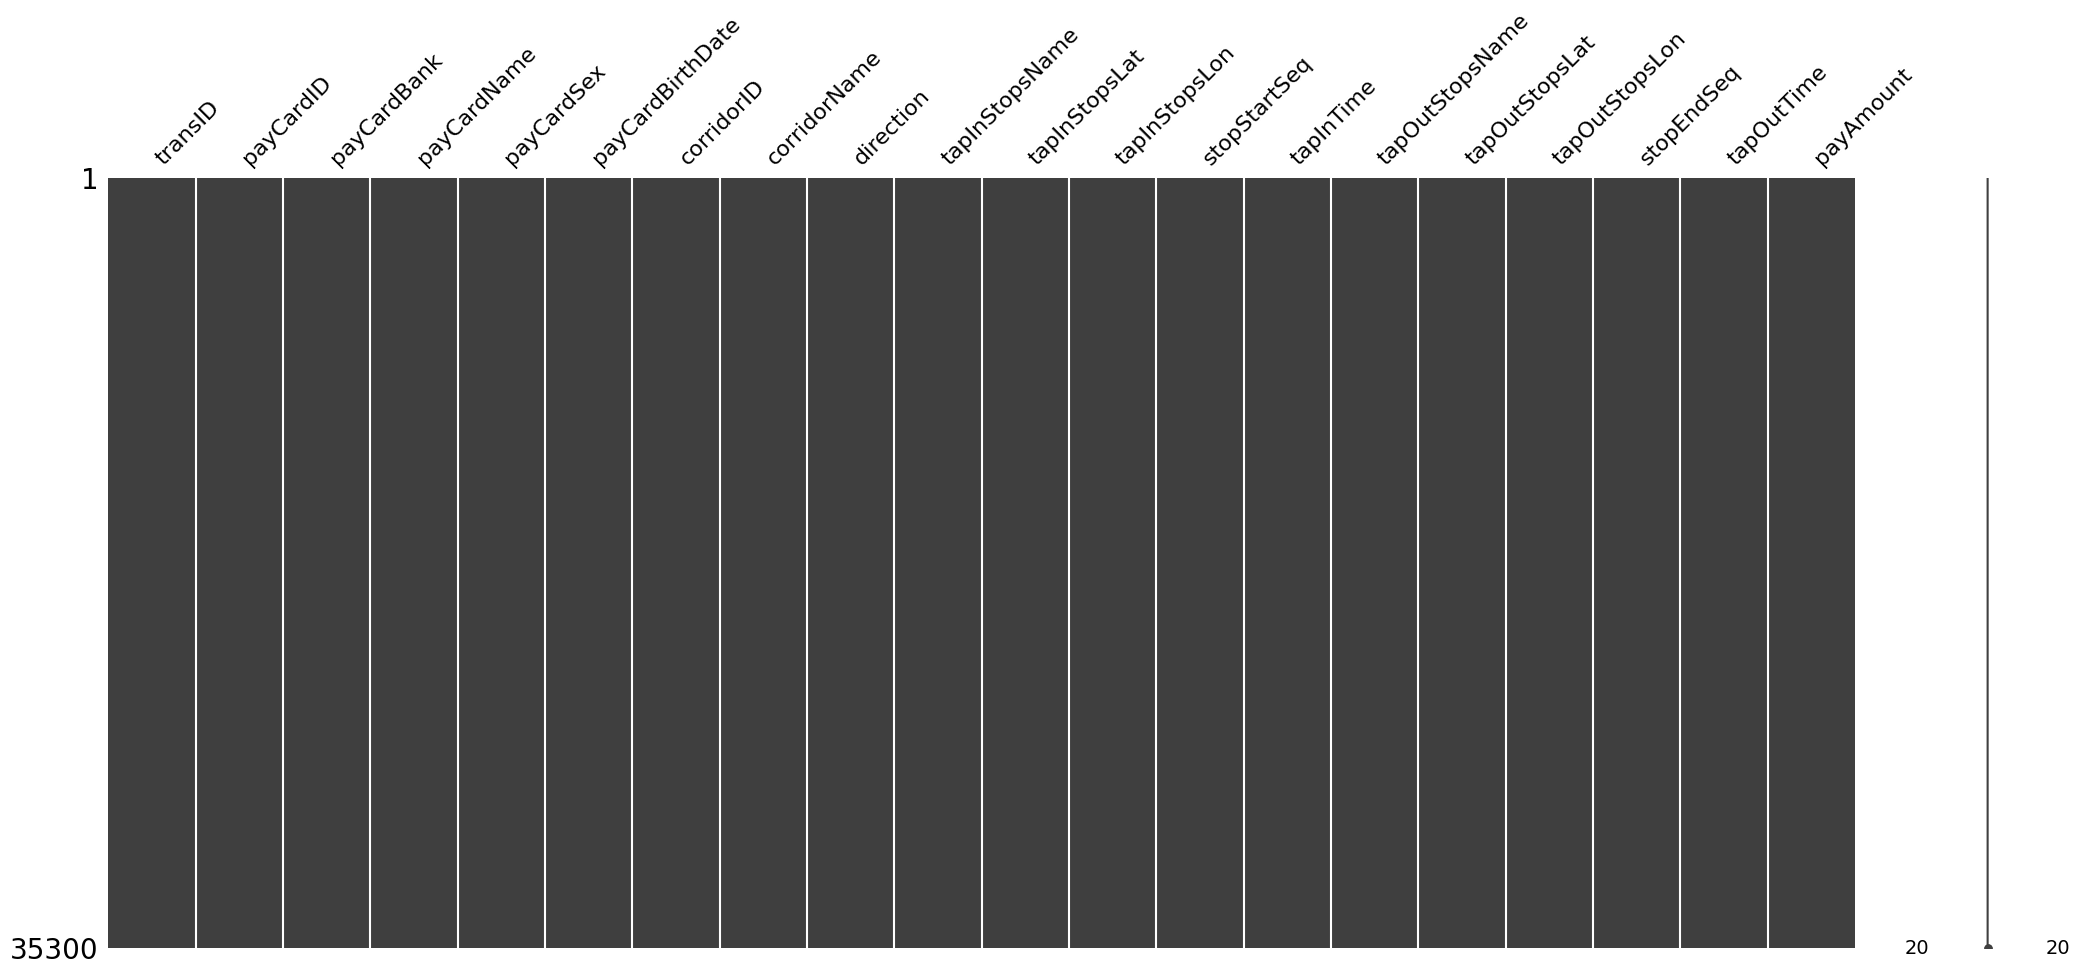

In [272]:
msno.matrix(df)

In [273]:
pd.set_option('display.max_colwidth', 60)
unique_items = []

for col in df.columns :
    unique_items.append( [col, df[col].nunique(), df[col].unique()])

raw_desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=unique_items)
raw_desc

,Column Name,Number of Unique,Unique Sample
0,transID,35300,"[EIIW227B8L34VB, LGXO740D2N47GZ, DJWR385V2U57TO, JTUZ800..."
1,payCardID,1976,"[180062659848800, 4885331907664776, 4996225095064169, 63..."
2,payCardBank,6,"[emoney, dki, flazz, online, brizzi, bni]"
3,payCardName,1969,"[Bajragin Usada, Gandi Widodo, Emong Wastuti, Surya Waca..."
4,payCardSex,2,"[M, F]"
5,payCardBirthDate,67,"[2008, 1997, 1992, 1978, 1982, 1993, 2004, 1984, 1988, 2..."
6,corridorID,221,"[5, 6C, R1A, 11D, 12, 1T, B14, 1Q, 5M, M7B, 9A, 4, JAK.4..."
7,corridorName,216,"[Matraman Baru - Ancol, Stasiun Tebet - Karet via Patra ..."
8,direction,2,"[1.0, 0.0]"
9,tapInStopsName,2512,"[Pal Putih, Kemenkes 2, Gg. Kunir II, Taman Elok 1, Sunt..."


In [274]:
df.isna().sum().sum()

np.int64(0)

In [275]:
display(df.shape, df.sample(5))

(35300, 20)

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
17441,UQVN483V5T16JW,213179781403691,emoney,Teddy Najmudin,F,2000,8D,Joglo - Blok M,0.0,Iskandar Muda,-6.244300,106.782490,9,2023-04-10 07:27:40,Masjid Nurul Iman Joglo,-6.217310,106.76208,23.0,2023-04-10 08:03:13,3500.0
1114,BNHY630O4Q31PZ,342522624491544,emoney,Dewi Gunawan,M,1975,JAK.27,Pulo Gebang - Rorotan,1.0,YPI Asyaadah,-6.191129,106.943820,34,2023-04-04 16:34:50,Jln. Komarudin Timur Lingkar Timur,-6.196226,106.94401,37.0,2023-04-04 18:00:33,0.0
2352,QIHW012R4S83FB,4798412351689028870,brizzi,Warsa Gunawan,F,1986,5B,Stasiun Tebet - BNN,1.0,BNN LRT,-6.245863,106.871143,1,2023-04-06 16:15:19,St. Tebet 1,-6.225576,106.85862,7.0,2023-04-06 17:46:55,3500.0
993,RORV439S9R38OU,676172975739,flazz,"Dr. Zaenab Wulandari, S.Ked",M,1996,12B,Pluit - Senen,0.0,Kota,-6.136790,106.814900,17,2023-04-04 17:46:34,Pangeran Jayakarta,-6.137611,106.81792,18.0,2023-04-04 18:50:31,3500.0
23656,KCBX706F1B53EF,4542110885190433,dki,"Ika Widiastuti, M.M.",M,1996,JAK.113,Rusun Sindang Koja - Kp. Sawah,1.0,Jln. B Lagoa Terusan 2,-6.108628,106.915050,13,2023-04-18 18:21:10,Jln. Lorong 19,-6.107881,106.89701,20.0,2023-04-18 20:09:24,0.0


In [276]:
print(f'Jumlah total entries sebelum proses cleaning = {len(tj_raw)}\n')
print(f'Jumlah total entries setelah proses cleaning = {len(df)}\n')
print(f'Persentase entries setelah proses cleaning = {round(len(df) / len(tj_raw) * 100, 2)}%')

Jumlah total entries sebelum proses cleaning = 37900

Jumlah total entries setelah proses cleaning = 35300

Persentase entries setelah proses cleaning = 93.14%


#### **Handle Outlier**

Selanjutnya, mari kita tindak lanjuti anomali seperti nilai `outlier` yang terdapat di dataset Transjakarta. Di bagian *inspeksi dataset* kita telah mengetahui terdapat anomali di kolom `payAmount` dan juga `durasi perjalanan penumpang`. 

Mempertimbangkan keputusan yang telah kita ambil berdasarkan *domain knowledge* terkait anomali di kolom `payAmount`, sekarang kita akan coba investigasi lebih lanjut untuk anomali di `durasi perjalanan`.

Sekarang kita buat kolom baru bernama `hours` dengan meng-ekstrak dari kolom `tapInTime` dan satu kolom baru lagi yaitu `travelTimeMnts` untuk mencari `durasi perjalanan` dari setiap penumpang dalam `satuan menit`.

In [277]:
df['travelTimeMnts'] = round((df['tapOutTime'] - df['tapInTime']).dt.total_seconds() / 60, 2)
df['hours'] = df['tapInTime'].dt.hour

display(df['travelTimeMnts'].sample(2), df['hours'].sample(2), df.sample(3))

5765     80.37
31322    34.67
Name: travelTimeMnts, dtype: float64

31879    21
13163     7
Name: hours, dtype: int32

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount,travelTimeMnts,hours
12880,KUEW292B8V48WD,3540608831782736,dki,Jasmani Tamba,M,2002,6P,Cibubur - Kuningan,0.0,Kuningan Timur 2,-6.235912,106.82765,3,2023-04-03 17:41:48,Kemenkes 1,-6.230706,106.83284,5.0,2023-04-03 19:01:15,20000.0,79.45,17
34376,BDMB430J5I67GJ,346111902361102,emoney,Ida Kusmawati,F,2007,JAK.01,Tanjung Priok - Plumpang,1.0,Sbr. Jln. Lagoa Kanal,-6.111783,106.88410,27,2023-04-29 05:36:34,PTT,-6.109953,106.88381,29.0,2023-04-29 07:10:02,0.0,93.47,5
23773,PHMG631G6C11TB,4866015896366005266,brizzi,Mahesa Tampubolon,M,1972,1F,Stasiun Palmerah - Bundaran Senayan,1.0,Senayan JCC Arah Barat,-6.213906,106.80841,2,2023-04-18 17:24:02,DPR MPR 2,-6.206314,106.80194,4.0,2023-04-18 19:10:36,3500.0,106.57,17


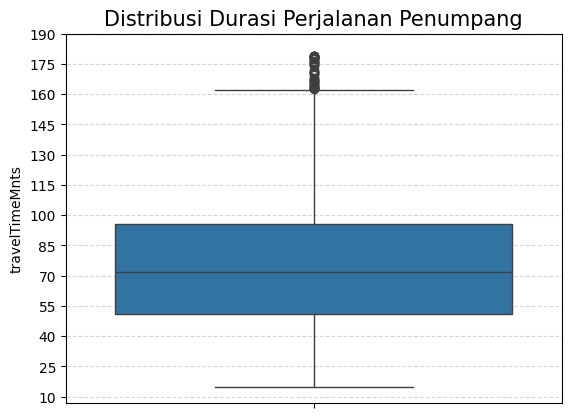

In [278]:
sns.boxplot(df['travelTimeMnts'])
plt.yticks(range(10,195,15))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title('Distribusi Durasi Perjalanan Penumpang', size=15)

plt.show()

Kita coba definisikan `outlier` di kolom `travelTimeMnts` dengan mencari `IQR` dari kolom tersebut.

In [279]:
Q1 = df['travelTimeMnts'].quantile(0.25)
Q3 = df['travelTimeMnts'].quantile(0.75)
IQR = Q3 - Q1
batas_bawah = Q1 - 1.5 * IQR
batas_atas = Q3 + 1.5 * IQR

outliers = df[(df['travelTimeMnts'] < batas_bawah) | (df['travelTimeMnts'] > batas_atas)]

In [280]:
display(
    len(index_anomali_waktu),
    len(outliers),
    outliers['travelTimeMnts'].min()
)

44

39

np.float64(162.73)

Berdasarkan `IQR`, ditemukan `39 outlier` perjalanan dengan durasi di atas `162 menit`. *Records* ini kita `drop` saja dari dataset karena dianggap tidak merepresentasikan durasi perjalanan wajar Transjakarta dan berpotensi disebabkan oleh kesalahan pencatatan sistem.

In [281]:
df = df.drop(index = outliers.index)
df.shape

(35261, 22)

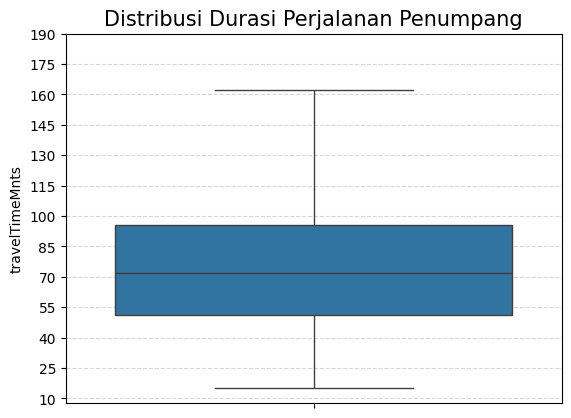

In [282]:
sns.boxplot(df['travelTimeMnts'])
plt.yticks(range(10,195,15))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title('Distribusi Durasi Perjalanan Penumpang', size=15)

plt.show()

## **Data Analysis**

Akhirnya, kita sekarang dapat memulai proses analisis terhadap dataset TransJakarta yang sudah kita persiapkan.

Untuk dapat menganalisis durasi perjalanan berdasarkan waktu, selain `hours` mari buat kolom seperti `date` dan `day` agar dapat menambah fitur terkait waktu di dataset TransJakarta.

In [283]:
df['date'] = df['tapInTime'].dt.date
df['days'] = df['tapInTime'].dt.day_name()

df = df.sort_values(by='tapInTime').reset_index(drop=True)

In [284]:
df.head()

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount,travelTimeMnts,hours,date,days
0,LDEA875J4U32YZ,213107623841273,emoney,Natalia Pratama,M,1964,11D,Pulo Gebang - Pulo Gadung 2 via PIK,0.0,United Tractors 1,-6.183260,106.93243,28,2023-04-01 06:22:27,Raya Penggilingan,-6.183068,106.93194,29.0,2023-04-01 08:15:45,3500.0,113.30,6,2023-04-01,Saturday
1,MSNJ848P3Q44GI,4139531858845,online,Tgk. Kacung Nashiruddin,F,1997,7E,Kampung Rambutan - Ragunan,1.0,Jln. Gabus Raya,-6.301222,106.83623,7,2023-04-01 06:54:35,RS Jantung Binawaluya,-6.308410,106.87071,15.0,2023-04-01 07:27:31,3500.0,32.93,6,2023-04-01,Saturday
2,JZZV014Y9O33OV,60459139923,flazz,Zelda Thamrin,M,1972,JIS3,Harmoni - Jakarta International Stadium,0.0,Danau Agung,-6.146869,106.85805,8,2023-04-01 07:32:50,Pecenongan,-6.167710,106.82819,12.0,2023-04-01 08:16:02,3500.0,43.20,7,2023-04-01,Saturday
3,EVRV919Q6A86EC,4301046448643115806,brizzi,Rama Firmansyah,F,1992,5C,PGC - Juanda,0.0,BKN,-6.257751,106.87000,1,2023-04-01 09:41:03,Cawang UKI,-6.250309,106.87360,2.0,2023-04-01 10:27:36,3500.0,46.55,9,2023-04-01,Saturday
4,MLDJ961C1Q41OU,3567863915368369,dki,"Ciaobella Prasetyo, S.Gz",F,1988,11D,Pulo Gebang - Pulo Gadung 2 via PIK,1.0,Gg. Aim 2,-6.200395,106.93515,13,2023-04-01 10:33:57,Walikota Jakarta Timur,-6.212540,106.94537,30.0,2023-04-01 12:12:59,3500.0,99.03,10,2023-04-01,Saturday


### **Distribusi Durasi Perjalanan Penumpang TransJakarta**

1. Bagaimana distribusi data durasi perjalanan penumpang TransJakarta?

In [285]:
df['travelTimeMnts'].describe()

count    35261.000000
mean        72.047866
std         27.870181
min         15.000000
25%         51.130000
50%         71.850000
75%         95.700000
max        161.930000
Name: travelTimeMnts, dtype: float64

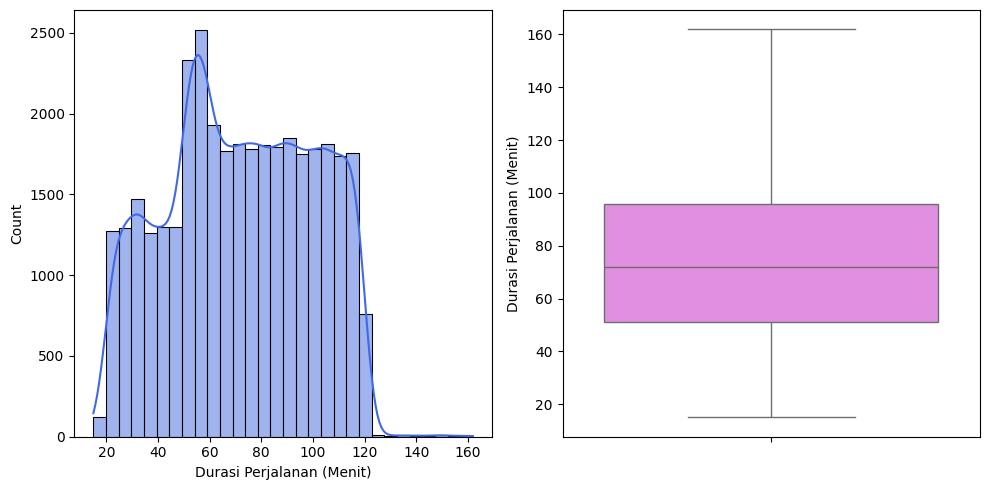

In [286]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

sns.histplot(df['travelTimeMnts'], kde=True, bins=30,ax=ax[0], color='royalblue')
sns.boxplot(df['travelTimeMnts'], ax=ax[1], color='violet')
ax[0].set_xlabel('Durasi Perjalanan (Menit)')
ax[1].set_ylabel('Durasi Perjalanan (Menit)')

plt.tight_layout();

Mari kita uji normalitas kolom `travelTimeMnts` dengan menggunakan `Kolmogorov-Smirnov Test` karena dataset TransJakarta yang cukup besar (35261 baris).

In [287]:
from scipy.stats import kstest

stats, pval = kstest(df['travelTimeMnts'], 'norm')
if pval <= 0.05:
    print('Distribusi tidak normal') #Ha
else:
    print('Distribusi Normal') #Ho

Distribusi tidak normal


### **10 Rute dengan Durasi Perjalanan dan Total Penumpang Tertinggi**

Kita akan coba mengidentifikasi:
* Rute dengan rata-rata durasi perjalanan tertinggi
* Rute dengan jumlah total penumpang tertinggi

Lalu kita akan coba gabungkan keduanya agar dapat menemukan **"rute kritis"** yang dapat menjadi fokus prioritas untuk optimasi tim operasional TransJakarta.

Pertama-tama, mari kita identifikasi 10 rute dengan durasi tertinggi.

In [288]:
rute_terlama = pd.DataFrame(df.groupby('corridorName')['travelTimeMnts'] \
               .mean().sort_values(ascending=False)).reset_index()
rute_terlama.head(10)

,corridorName,travelTimeMnts
0,Kampung Rambutan - Blok M,83.659375
1,Cinere - Kuningan,83.113929
2,Stasiun Palmerah - Tosari,81.436966
3,Rawamangun - Klender,80.641413
4,Tanah Abang - Kebayoran Lama via Pos Pengumben,80.070455
5,Senen - Pulo Gadung via Kelapa Gading,79.610326
6,Pinang Ranti - Bundaran Senayan,79.606319
7,Grogol - Tubagus Angke,79.417647
8,Grogol - Pos Pengumben via Slipi,78.831951
9,Kelapa Gading - Rusun Kemayoran,78.759612


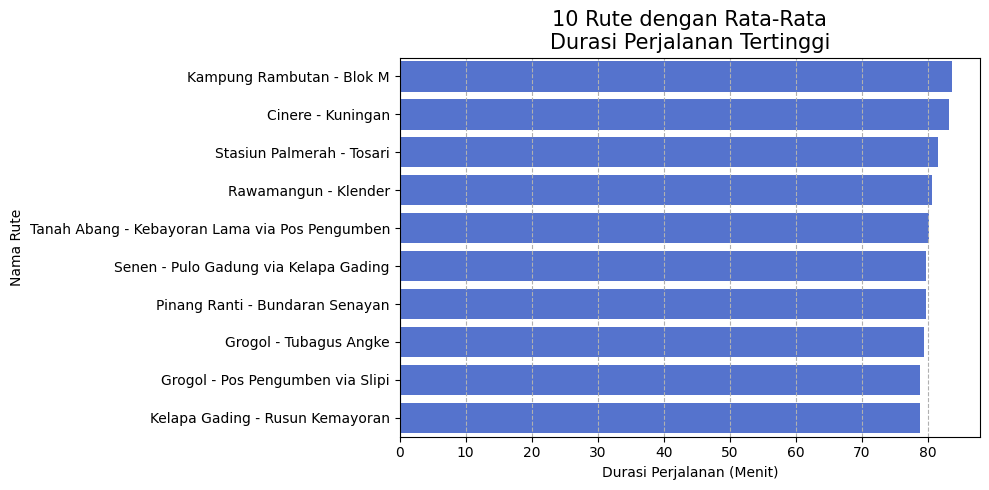

In [289]:
plt.figure(figsize=(10,5))
sns.barplot(rute_terlama.head(10), y='corridorName', x='travelTimeMnts', color='royalblue')
plt.title('10 Rute dengan Rata-Rata\nDurasi Perjalanan Tertinggi', size=15)
plt.xlabel('Durasi Perjalanan (Menit)')
plt.ylabel('Nama Rute')
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()

Rata-rata durasi tertinggi secara keseluruhan rute adalah **72 menit**, namun ditemukan bahwa terdapat 3 rute dengan durasi perjalanan lebih dari 80 menit, dan semuanya berada di ruas jalan area `Jakarta Selatan`:

* Kampung Rambutan - Blok M **(83.6 menit)**
* Cinere - Kuningan **(83.1 menit)**
* Stasiun Palmerah - Tosari **(81.4 menit)**

Masuk akal karena area Jakarta Selatan didominasi oleh [pusat bisnis dan perkantoran](https://www.rumah123.com/panduan-properti/tips-properti-114862-area-perkantoran-jakarta-id.html), sehingga:

* Lalu lintas lebih padat, terutama pada jam sibuk
* Durasi perjalanan cenderung lebih lama

Mengacu kepada [Google Maps direction](https://maps.app.goo.gl/W4R4qDaF7wd2Xqyv6), **rute Kampung Rambutan – Blok M** menggunakan kendaraan pribadi hanya memakan waktu 35–45 menit. Gap ini menjadi indikasi bahwa transportasi publik belum sepenuhnya kompetitif dalam hal waktu tempuh.

Sekarang mari kita coba lihat frekuensi interval dari setiap armada di ketiga rute dengan durasi paling tinggi ini.

In [290]:
display(
    len(df['corridorName'].unique()),
    len(df[df['corridorName'].str.contains('Kampung Rambutan - Blok M')]),
    len(df[df['corridorName'].str.contains('Cinere - Kuningan')]),
    len(df[df['corridorName'].str.contains('Stasiun Palmerah - Tosari')]),
    )

216

16

84

145

Dari sini kita bisa lihat bahwa rute **Kampung Rambutan - Blok M** hanya terdiri dari 16 penumpang saja, dan cukup timpang jika dibandingkan dengan 2 rute lainnya.

Selanjutnya kita akan coba gabungkan hasil analisa dari **10 rute dengan durasi tertinggi** dan juga memiliki **volume penumpang yang paling padat**. Agar kita dapat mengidentifikasi rute mana saja yang dapat menjadi prioritas utama untuk efisiensi operasional TransJakarta.

In [291]:
rute_terpadat = pd.DataFrame(df['corridorName'] \
                .value_counts().sort_values(ascending=False)).reset_index().rename(columns={'count':'penumpang'})
rute_terpadat.head(10)

,corridorName,penumpang
0,Cibubur - Balai Kota,383
1,Ciputat - CSW,375
2,Harmoni - Jakarta International Stadium,332
3,Pulo Gadung - Monas,330
4,Kampung Rambutan - Pondok Gede,327
5,Rusun Pondok Bambu - Walikota Jakarta Timur,323
6,Kalideres - Bundaran HI via Veteran,322
7,Kebayoran Lama - Tanah Abang,321
8,Rusun Rawa Bebek - Kodamar,305
9,BKN - Blok M,297


In [292]:
display(len(rute_terlama), len(rute_terpadat))

216

216

In [293]:
rute_kritis = pd.merge(rute_terpadat, rute_terlama, on='corridorName') \
	.sort_values(['penumpang', 'travelTimeMnts'], ascending=[False, False]) \
	.head(10)
rute_kritis

,corridorName,penumpang,travelTimeMnts
0,Cibubur - Balai Kota,383,71.939164
1,Ciputat - CSW,375,75.847120
2,Harmoni - Jakarta International Stadium,332,71.945572
3,Pulo Gadung - Monas,330,71.769909
4,Kampung Rambutan - Pondok Gede,327,71.904312
5,Rusun Pondok Bambu - Walikota Jakarta Timur,323,73.786440
6,Kalideres - Bundaran HI via Veteran,322,69.548944
7,Kebayoran Lama - Tanah Abang,321,73.509938
8,Rusun Rawa Bebek - Kodamar,305,74.379836
9,BKN - Blok M,297,73.384007


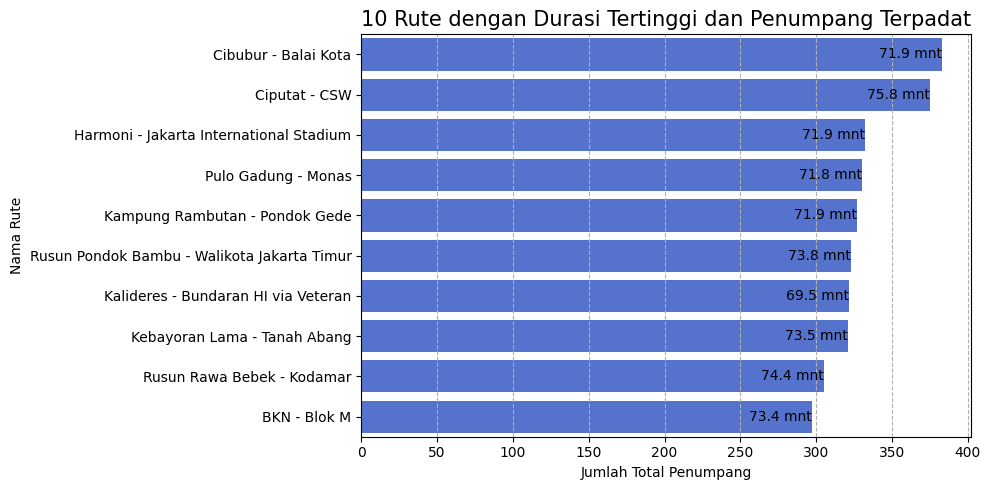

In [294]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=rute_kritis,
    y='corridorName',
    x='penumpang',
    color='royalblue'
)

plt.title('10 Rute dengan Durasi Tertinggi dan Penumpang Terpadat', size=15)
plt.xlabel('Jumlah Total Penumpang')
plt.ylabel('Nama Rute')
plt.grid(axis='x', linestyle='--')

for i, row in rute_kritis.iterrows():
    ax.text(
        row['penumpang'],
        i,
        f"{row['travelTimeMnts']:.1f} mnt",
        color='black',
        ha='right',
        va='center',
        fontsize=10,
    )

plt.tight_layout()
plt.show()

In [295]:
display(
        df[df['corridorName'] == 'Cibubur - Balai Kota']['transID'].count(),
        df[df['corridorName'] == 'Ciputat - CSW']['transID'].count())

np.int64(383)

np.int64(375)

Dengan menggabungkan 10 rute dengan durasi dan volume penumpang tertinggi, ditemukan bahwa:

* Rute-rute seperti Cibubur – Balai Kota dan Ciputat – CSW memiliki volume penumpang besar sekaligus durasi panjang. 
* Kita menemukan adanya beban operasional, baik dari sisi lalu lintas maupun kapasitas armada.

Rute-rute kritis ini layak menjadi prioritas dalam strategi efisiensi, seperti:

* Memperpendek interval armada agar dapat mengatasi potensi penumpang yang menumpuk dan efisiensi perputaran armada yang beroperasi.

---

### **Volume Penumpang TransJakarta Per Jam**

Langkah selanjutnya adalah membandingkan **kepadatan penumpang** per jam untuk mengidentifikasi jam operasional dengan volume penumpang tertinggi (jam sibuk) dan apakah durasi tinggi ini juga disebabkan oleh lonjakan volume pengguna.

Mari kita hitung jumlah penumpang dalam setiap jamnya dan kita `sort_values()` berdasarkan kolom `hours`.

In [296]:
penumpang_per_jam = df.groupby('hours')['transID'].count()
penumpang_per_jam = penumpang_per_jam.reset_index(name='jumlah_penumpang')
penumpang_per_jam

,hours,jumlah_penumpang
0,5,3122
1,6,5426
2,7,2590
3,8,2701
4,9,2625
5,10,273
6,11,320
7,12,313
8,13,330
9,14,158


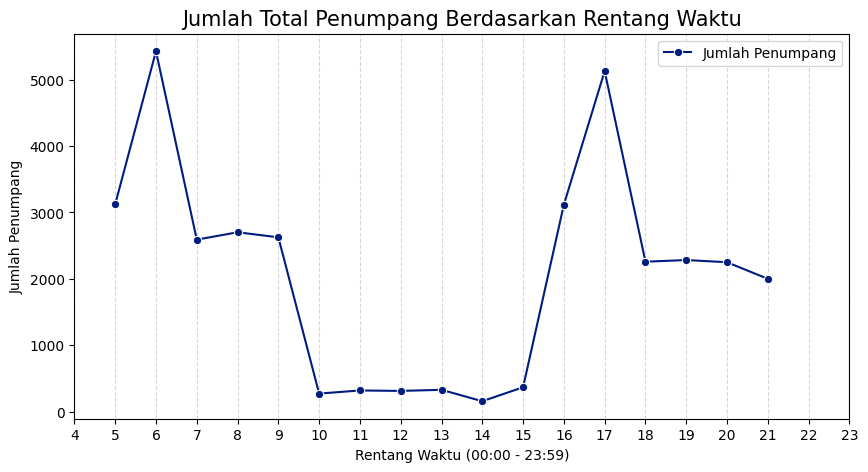

In [297]:
plt.figure(figsize=(10,5))
sns.lineplot(penumpang_per_jam.set_index('hours'), markers='o', palette='dark')
plt.xticks(range(4,24))
plt.xlabel('Rentang Waktu (00:00 - 23:59)')
plt.ylabel('Jumlah Penumpang')
plt.title('Jumlah Total Penumpang Berdasarkan Rentang Waktu', size=15)
plt.legend(['Jumlah Penumpang'])
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

In [298]:
df.groupby('hours')['travelTimeMnts'].mean()

hours
5     42.977056
6     54.903474
7     69.519340
8     70.818752
9     70.109463
10    69.604725
11    66.375750
12    70.430447
13    69.766212
14    67.671392
15    79.543913
16    84.126843
17    83.903201
18    83.917879
19    83.471003
20    83.740093
21    83.445005
Name: travelTimeMnts, dtype: float64

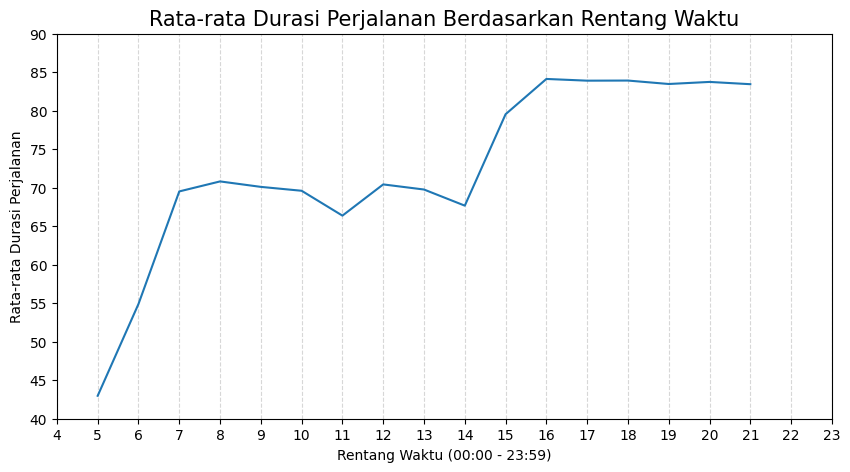

In [299]:
plt.figure(figsize=(10,5))
sns.lineplot(df.groupby('hours')['travelTimeMnts'].mean().sort_values(ascending=False), palette='dark')
plt.xticks(range(4,24))
plt.yticks(range(40,91,5))
plt.xlabel('Rentang Waktu (00:00 - 23:59)')
plt.ylabel('Rata-rata Durasi Perjalanan')
plt.title('Rata-rata Durasi Perjalanan Berdasarkan Rentang Waktu', size=15)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

Tampaknya ditemukan dua periode **jam sibuk**:
* **Pagi hari (05:00-08:00)** dengan volume penumpang tertinggi di jam **06:00**
    * Masuk akal karena ini adalah rentang waktu warga Jakarta memulai berbagai aktivitas seperti berangkat kerja, sekolah, dsb.
* **Sore hari (16:00-18:00)** dengan volume penumpang tertinggi di jam **17:00**
    * Sebaliknya, ini adalah rentang waktu warga Jakarta pulang dari kantor, atau menuju lokasi tujuan untuk melakukan aktivitas lain.

Sebaliknya, jam **10.00–15.00** menunjukkan volume penumpang yang rendah, cocok untuk penerapan uji coba layanan ekspres *(skip-stop)* untuk rute-rute yang sepi penumpang. Mari kita coba identifikasi rute-rute tersebut.

In [300]:
rute_sepi = df.groupby('corridorName')['transID'].count().sort_values().head()
rute_sepi

corridorName
Kampung Rambutan - Blok M                         16
Tanah Abang - Kebayoran Lama via Pos Pengumben    22
Term. Pulo Gadung - Lampiri                       31
Senen - Tanah Abang                               38
Gondangdia - Balai Kota                           39
Name: transID, dtype: int64

In [301]:
df[df['corridorName'].isin(rute_sepi.index)].groupby('corridorName')['travelTimeMnts'].mean().reset_index()

,corridorName,travelTimeMnts
0,Gondangdia - Balai Kota,74.946923
1,Kampung Rambutan - Blok M,83.659375
2,Senen - Tanah Abang,71.903947
3,Tanah Abang - Kebayoran Lama via Pos Pengumben,80.070455
4,Term. Pulo Gadung - Lampiri,78.501290


Berdasarkan temuan ini, kita dapat menerapkan uji coba layanan ekspres *(skip-stop)* di 5 rute ini. Dengan begitu, kita dapat melakukan redistribusi armada agar dapat memperpendek interval kedatangan armada di jam sibuk, khususnya di 10 rute kritis yang telah kita identifikasi sebelumnya.

---

### **Segmentasi Penumpang di Jam Sibuk**

Kemudian kita akan coba identifikasi kelompok usia dominan pada jam sibuk (pagi dan sore), agar alokasi armada dan jenis layanan bisa disesuaikan dengan kebutuhan pengguna sesuai dengan segmentasi penumpang Transjakarta.

Pertama-tama, kita akan buat kolom baru `age` dengan cara 2023 - `payCardBirthDate`, dan kemudian kita akan tambahkan kolom `ageGroup` sebagai label segmentasi usia penumpang Transjakarta.

In [302]:
df['age'] = 2023 - df['payCardBirthDate']

In [303]:
bins = [0, 18, 30, 45, 60, df['age'].max()]
labels = ['0-18', '19-30', '31-45', '46-60', '60+']

In [304]:
df['ageGroup'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

df.sample(2)

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount,travelTimeMnts,hours,date,days,age,ageGroup
15731,JKIQ906Q9F66UX,378346560438229,emoney,Radit Usamah,F,1974,T11,Poris Plawad - Bundaran Senayan,1.0,Islamic,-6.228521,106.61473,8,2023-04-14 17:08:40,Victoria Park 2,-6.197681,106.62187,16.0,2023-04-14 18:12:25,3500.0,63.75,17,2023-04-14,Friday,49,46-60
12801,AAEF231Y0J60PI,4974804949914047,dki,Gangsar Siregar,M,1996,2A,Pulo Gadung - Rawa Buaya via Balai Kota,1.0,Pulo Mas,-6.174736,106.89277,22,2023-04-13 05:50:48,Pulo Gadung 1,-6.183239,106.90907,24.0,2023-04-13 06:44:12,3500.0,53.40,5,2023-04-13,Thursday,27,19-30


In [305]:
rush_hours = df[((df['hours'] >= 5) & (df['hours'] <= 9)) | \
            ((df['hours'] >= 16) & (df['hours'] <= 19))]

rush_hours.sample(2)

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount,travelTimeMnts,hours,date,days,age,ageGroup
23846,JATE365N2G73IK,6543676226758108,dki,Kairav Rajasa,F,2002,5N,Kampung Melayu - Ragunan,0.0,GPIB Bukit Moria,-6.241727,106.84454,16,2023-04-20 06:53:57,Sbr. SMK Al Hidayah 1,-6.308208,106.81387,45.0,2023-04-20 08:39:53,3500.0,105.93,6,2023-04-20,Thursday,21,19-30
1167,CMNY052Y7A06EJ,4755059063340087074,brizzi,"Puti Lili Nuraini, M.TI.",M,1984,3B,Rusun Flamboyan - Cengkareng,1.0,Sekolah Al Huda 1,-6.149731,106.72736,2,2023-04-03 18:18:00,Puskesmas Cengkareng,-6.144546,106.72866,4.0,2023-04-03 19:13:15,0.0,55.25,18,2023-04-03,Monday,39,31-45


Selanjutnya, untuk dapat mengetahui demografi penumpang yang paling dominan menggunakan layanan Transjakarta di jam sibuk, kita dapat lakukan segmentasi berdasarkan kolom `ageGroup` khusus pada rentang waktu 05:00–09:00 dan 16:00–19:00.

In [306]:
segmentasi_usia = rush_hours['ageGroup'].value_counts().sort_index()
segmentasi_usia

ageGroup
0-18      4689
19-30     7864
31-45    11963
46-60     4161
60+        572
Name: count, dtype: int64

In [307]:
persentase_usia = (segmentasi_usia / segmentasi_usia.sum()) * 100
persentase_usia

ageGroup
0-18     16.031317
19-30    26.886389
31-45    40.900544
46-60    14.226127
60+       1.955622
Name: count, dtype: float64

In [308]:
pie_df = persentase_usia.reset_index()
pie_df.columns = ['ageGroup', 'percentage']

In [309]:
fig = px.pie(
    pie_df,
    names='ageGroup',
    values='percentage',
    title='Segmentasi Penumpang Transjakarta di Jam Sibuk',
    color_discrete_sequence=px.colors.sequential.Blues_r,
    hole=0.5
)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title_font_size=15)
fig.show()

Berdasarkan segmentasi penumpang pada jam sibuk **(05.00–09.00 dan 16.00–19.00)**, terlihat bahwa:

* **40.9% penumpang merupakan usia 31–45 tahun**, yang kemungkinan besar adalah pekerja kantoran.
* Disusul oleh **segmen 19–30 tahun** sebesar 26.9%, mencakup mahasiswa dan pekerja *entry-level*.
* **16% penumpang berasal dari usia 0–18 tahun**, menunjukkan adanya pelajar yang ikut menggunakan layanan saat jam sibuk.

Temuan ini mendukung kebijakan operasional seperti:
* Menyesuaikan **interval keberangkatan armada** dengan jam kerja dan jam sekolah yang berarti membutuhkan armada yang lebih banyak agar mampu merespon jam sibuk dengan lebih cepat.

---

### **Berdasarkan Weekday & Weekend**

Selanjutnya kita akan coba identifikasi perbedaan durasi perjalanan saat **hari kerja (weekday)** dan **akhir pekan (weekend)** beserta dengan volume penumpangnya.

In [310]:
df['weekend'] = df['tapInTime'].dt.dayofweek >= 5
df.sample(3)

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount,travelTimeMnts,hours,date,days,age,ageGroup,weekend
24540,CIAG986T3H06UW,3549191016294752,dki,"T. Gangsa Hutasoit, S.IP",M,1985,JAK.27,Pulo Gebang - Rorotan,0.0,Masjid At Taqwa Karang Tengah,-6.151522,106.97204,45,2023-04-20 17:50:07,Simpang KH Abdulloh Karang Tengah 1,-6.147051,106.97188,47.0,2023-04-20 19:22:33,0.0,92.43,17,2023-04-20,Thursday,38,31-45,False
30433,PKAY537U6Q05FL,180097982588566,emoney,"Kamaria Megantara, S.IP",M,1997,9H,Blok M - Universitas Indonesia,1.0,Tj. Mas Raya,-6.308428,106.83910,31,2023-04-26 06:42:16,Gg. Kancil I Lenteng Agung,-6.316507,106.83774,34.0,2023-04-26 07:15:30,3500.0,33.23,6,2023-04-26,Wednesday,26,19-30,False
5632,ZAMU719B3O28PV,4074114259011835374,brizzi,Vero Hutagalung,F,1983,JAK.31,Blok M - Andara,1.0,Child Care Pre School,-6.257557,106.80090,48,2023-04-06 17:58:50,Blok M Jalur 4,-6.243474,106.80188,57.0,2023-04-06 19:44:00,0.0,105.17,17,2023-04-06,Thursday,40,31-45,False


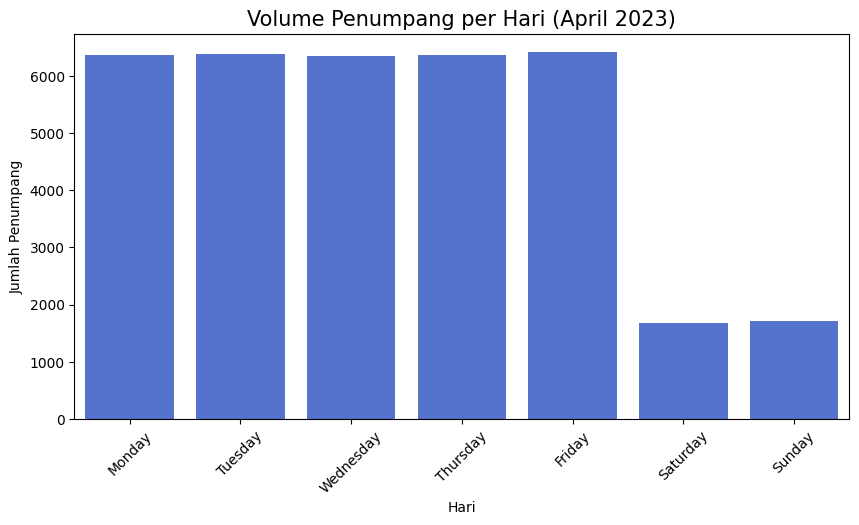

In [311]:
plt.figure(figsize=(10, 5))
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df, x='days', order=order, color='royalblue')
plt.title('Volume Penumpang per Hari (April 2023)', size=15)
plt.xlabel('Hari')
plt.ylabel('Jumlah Penumpang')
plt.xticks(rotation=45)

plt.show()

Berdasarkan *chart* di atas memang terlihat jumlah total penumpang yang berbeda secara signifikan, dimana pada hari kerja, jumlah total penumpang mencapai lebih dari **6 ribu orang**, sedangkan pada saat akhir pekan (*weekend*) jumlahnya menurun hingga kurang dari **2 ribu orang**.

Mari kita coba lihat jumlah penumpang antara hari kerja dan akhir pekan dalam setiap jam nya.

In [312]:
weekend = df[df['weekend'] == True].groupby('hours')['transID'].count()
weekday = df[df['weekend'] == False].groupby('hours')['transID'].count()

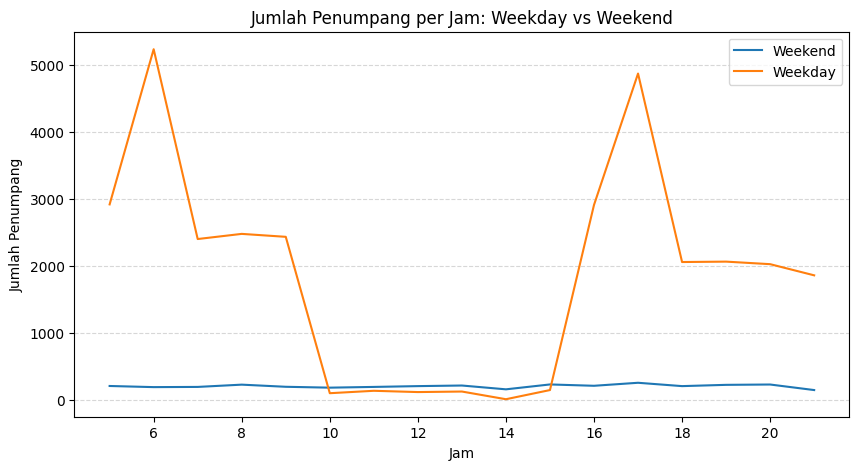

In [313]:
plt.figure(figsize=(10,5))
sns.lineplot(x=weekend.index, y=weekend.values, label='Weekend')
sns.lineplot(x=weekday.index, y=weekday.values, label='Weekday')

plt.xlabel('Jam')
plt.ylabel('Jumlah Penumpang')
plt.title('Jumlah Penumpang per Jam: Weekday vs Weekend')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

Sedangkan untuk jam sibuk di akhir pekan tampaknya tidak menghadirkan lonjakan volume penumpang. Berdasarkan temuan ini, kita dapat fokus optimasi operasional terhadap jam sibuk, dengan fokus di hari kerja yaitu Senin-Jumat.

---

### **Korelasi Rute dengan Waktu Tap-In**

Selanjutnya kita akan coba identifikasi korelasi antara **waktu tap-in (jam)** dan **lokasi (rute)** dengan jumlah penumpang tertinggi.

1. Kapan dan dimana terjadi lonjakan penumpang?
1. Rute mana yang selalu padat penumpang sepanjang hari?

In [314]:
rute_terpadat = df['corridorName'].value_counts().head(10)

df_top = df[df['corridorName'].isin(rute_terpadat.index)]
df_top.head()

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount,travelTimeMnts,hours,date,days,age,ageGroup,weekend
2,JZZV014Y9O33OV,60459139923,flazz,Zelda Thamrin,M,1972,JIS3,Harmoni - Jakarta International Stadium,0.0,Danau Agung,-6.146869,106.85805,8,2023-04-01 07:32:50,Pecenongan,-6.167710,106.82819,12.0,2023-04-01 08:16:02,3500.0,43.20,7,2023-04-01,Saturday,51,46-60,True
14,RCZV713P0N65YK,213164568637687,emoney,R.M. Legawa Prastuti,F,1968,S21,Ciputat - CSW,1.0,Antena III,-6.250453,106.79171,4,2023-04-02 09:00:50,Komplek Uin,-6.308924,106.75601,23.0,2023-04-02 10:26:47,3500.0,85.95,9,2023-04-02,Sunday,55,46-60,True
39,DDES630K2F80KC,2251412124634980,dki,Tirta Siregar,F,1993,1T,Cibubur - Balai Kota,0.0,Benhil 3,-6.216010,106.81632,3,2023-04-03 05:08:01,Grand Sahid,-6.210975,106.82059,6.0,2023-04-03 05:52:25,20000.0,44.40,5,2023-04-03,Monday,30,19-30,False
43,IPRG491M6Z87AX,676170059098,flazz,"Dt. Vinsen Budiyanto, S.H.",F,2009,3,Kalideres - Bundaran HI via Veteran,1.0,Jembatan Gantung,-6.155513,106.74946,8,2023-04-03 05:10:56,Rawa Buaya,-6.153908,106.72619,11.0,2023-04-03 05:58:34,3500.0,47.63,5,2023-04-03,Monday,14,0-18,False
48,PNHJ396O9J75XG,4450080570279470,dki,"Ani Wasita, M.Pd",M,2004,8C,Kebayoran Lama - Tanah Abang,1.0,Jln. Taman Kb. Sirih,-6.182295,106.81661,5,2023-04-03 05:12:16,SMAN 24,-6.210598,106.79631,21.0,2023-04-03 05:35:12,3500.0,22.93,5,2023-04-03,Monday,19,19-30,False


In [315]:
heatmap_data = df_top.pivot_table(index='corridorName',columns='hours',aggfunc='size',fill_value=0)

heatmap_data

hours,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
corridorName,,,,,,,,,,,,,,,,,
BKN - Blok M,19,41,25,25,28,0,4,3,1,0,6,24,39,20,21,16,25
Cibubur - Balai Kota,26,62,29,35,39,0,1,2,0,1,0,25,64,21,32,22,24
Ciputat - CSW,16,47,33,41,45,5,3,3,0,1,3,11,37,33,27,31,39
Harmoni - Jakarta International Stadium,32,52,30,20,27,2,4,2,0,0,0,35,40,29,17,21,21
Kalideres - Bundaran HI via Veteran,57,52,17,13,11,4,3,5,5,2,5,45,61,12,8,13,9
Kampung Rambutan - Pondok Gede,21,63,25,26,23,1,2,1,0,1,1,35,39,23,25,19,22
Kebayoran Lama - Tanah Abang,40,57,19,22,19,1,2,0,2,1,2,30,61,20,22,9,14
Pulo Gadung - Monas,33,52,32,12,29,2,2,2,1,1,2,34,61,12,14,20,21
Rusun Pondok Bambu - Walikota Jakarta Timur,20,54,27,29,28,1,1,2,1,0,0,24,37,24,26,27,22


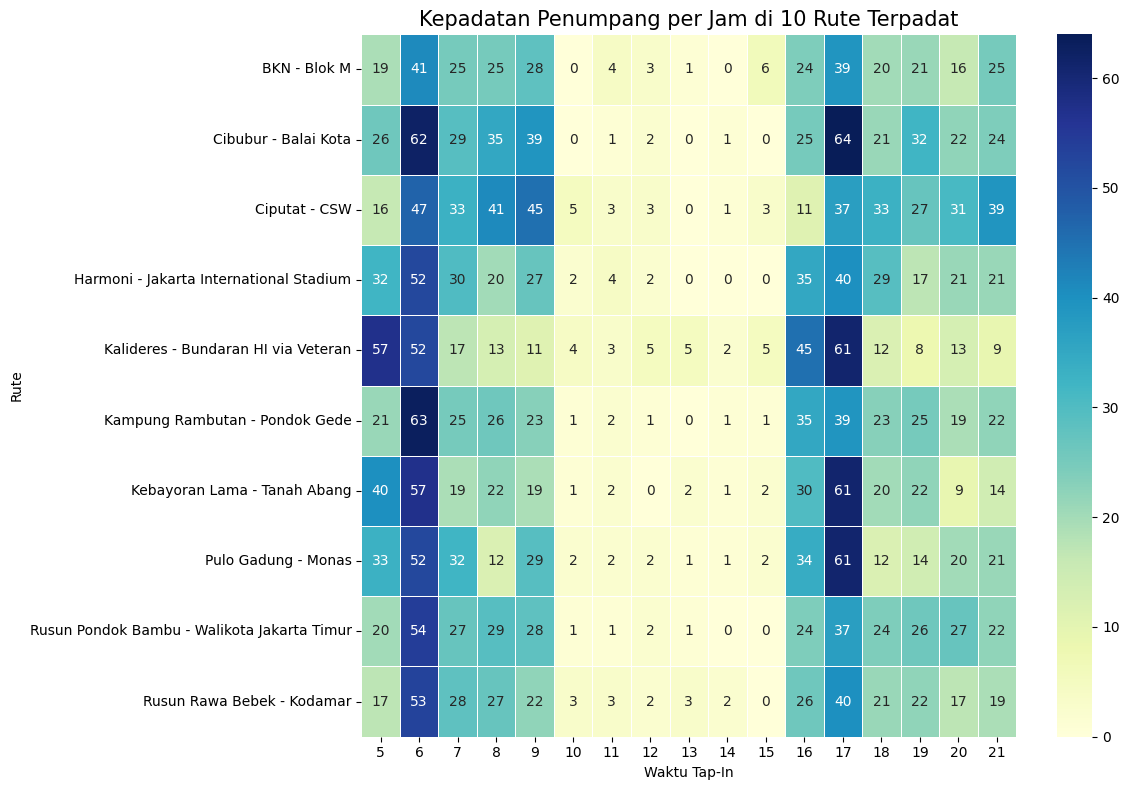

In [316]:
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data,cmap="YlGnBu",linewidths=0.5,annot=True,fmt='d')
plt.title('Kepadatan Penumpang per Jam di 10 Rute Terpadat', fontsize=15)
plt.xlabel('Waktu Tap-In')
plt.ylabel('Rute')

plt.tight_layout();

Berdasarkan `heatmap` diatas, terdapat **key-findings**:
1. Mayoritas rute mengalami lonjakan penumpang pada jam **05:00–07:00 dan 16:00–18:00**, yang **memvalidasi pola jam sibuk**.
1. Beberapa rute seperti:
    * Cibubur - Balai Kota
    * Kalideres - Bundaran HI via Veteran
    * Kampung Rambutan – Pondok Gede
    * Kebayoran Lama - Tanah Abang
    * Pulo Gadung - Monas

Memiliki **volume kepadatan penumpang yang tinggi di jam sibuk pagi maupun saat jam sibuk sore**. 

---

### **Uji Hipotesis**

Kita ingin mengetahui apakah **rata-rata waktu perjalanan saat jam sibuk** (05:00–09:00 dan 16:00–19:00) berbeda secara signifikan dengan diluar jam sibuk.

In [317]:
not_rush_hours = df[~df.index.isin(rush_hours.index)]

In [318]:
stats, pval = kstest(rush_hours['travelTimeMnts'], 'norm')
if pval <= 0.05:
    print('Distribusi tidak normal') #Ha
else:
    print('Distribusi Normal') #Ho

Distribusi tidak normal


In [319]:
stats, pval = kstest(not_rush_hours['travelTimeMnts'], 'norm')
if pval <= 0.05:
    print('Distribusi tidak normal') #Ha
else:
    print('Distribusi Normal') #Ho

Distribusi tidak normal


Kita akan melakukan **uji banding rata-rata non-parametrik** karena distribusi datanya tidak normal. Oleh karena itu, kita gunakan `Mann Whitney` untuk membandingkan durasi perjalanan di jam sibuk dan di luar jam sibuk. 

In [320]:
from scipy.stats import mannwhitneyu

h0 = 'Tidak terdapat perbedaan rata-rata durasi perjalanan saat jam sibuk dan di luar jam sibuk.'
ha = 'Terdapat perbedaan rata-rata durasi perjalanan yang signifikan saat jam sibuk dan di luar jam sibuk.'

stat, pval = mannwhitneyu(rush_hours['travelTimeMnts'], not_rush_hours['travelTimeMnts'], alternative='two-sided')

print(f'U-Statistic: {stat}, p-value: {pval}')

if pval <= 0.05:
    print('Tolak H0')
    print(ha)
else:
    print('Gagal menolak H0')
    print(h0)

U-Statistic: 70518462.5, p-value: 1.68264148526692e-129
Tolak H0
Terdapat perbedaan rata-rata durasi perjalanan yang signifikan saat jam sibuk dan di luar jam sibuk.


Hal ini memperkuat bahwa **jam sibuk memiliki karakteristik operasional yang berbeda**, kemungkinan besar menyebabkan durasi lebih panjang akibat:
- **Kepadatan lalu lintas** di koridor utama dan kawasan pusat aktivitas
- **Tingginya jumlah penumpang** per kendaraan, memperlama proses naik–turun
- **Potensi keterlambatan** transfer di halte sibuk

Insight ini bisa dijadikan **bukti kuat** untuk:
- Mempertimbangkan langkah **optimasi interval armada** pada jam sibuk
- Menyediakan layanan **ekspres (skip-stop)** di luar jam sibuk
- **Relokasi armada** agar operasional dapat merespon pola penumpang di jam sibuk dengan lebih efisien

---

### **Strategi Ekspres (Skip-Stop)**

Kali ini kita akan coba melihat apakah strategi ekspres (skip-stop) benar-benar dapat memberikan perubahan atau tidak untuk rute-rute dengan durasi perjalanan yang tinggi. Kita akan coba lihat rute **Kampung Rambutan - Blok M** karena ini adalah rute dengan durasi tertinggi namun sepi penumpang.

In [321]:
top_rute_terlama = df[df['corridorName'] == 'Kampung Rambutan - Blok M']

Selanjutnya, mari kita analisis struktur jalur untuk rute dengan durasi perjalanan paling tinggi (Kampung Rambutan – Blok M) dimana kita ingin mencari tahu berapa banyak halte (tap-out) yang dilalui, dan halte mana yang paling sering dipakai sebagai titik naik (tap-in).

In [322]:
n_tap_in = top_rute_terlama['tapInStopsName'].nunique()
n_tap_out = top_rute_terlama['tapOutStopsName'].nunique()

print(f"Jumlah halte naik unik: {n_tap_in}")
print(f"Jumlah halte turun unik: {n_tap_out}")

Jumlah halte naik unik: 16
Jumlah halte turun unik: 14


Dari sini kita dapat mengetahui bahwa struktur rute Kampung Rambutan - Blok M memiliki maksimum panjang rute tercatat dengan total sampai **30 halte**. 

In [323]:
top_rute_terlama['jalur_panjang'] = top_rute_terlama['stopEndSeq'] - top_rute_terlama['stopStartSeq']

top_rute_terlama['jalur_panjang'].describe()

count    16.000000
mean     14.062500
std       9.066192
min       1.000000
25%       7.000000
50%      13.500000
75%      19.000000
max      33.000000
Name: jalur_panjang, dtype: float64

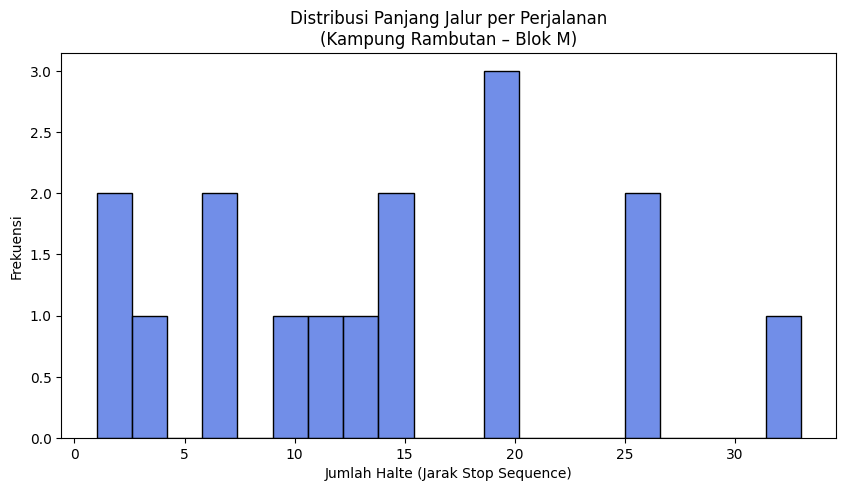

In [324]:
plt.figure(figsize=(10,5))
sns.histplot(top_rute_terlama['jalur_panjang'], bins=20, color='royalblue')
plt.title('Distribusi Panjang Jalur per Perjalanan\n(Kampung Rambutan – Blok M)')
plt.xlabel('Jumlah Halte (Jarak Stop Sequence)')
plt.ylabel('Frekuensi')

plt.show()

Distribusi panjang jalur yang cukup besar menunjukkan bahwa banyak armada berhenti di terlalu banyak titik, meskipun tidak semuanya merupakan halte padat.

Berdasarkan temuan ini, **strategi skip-stop dapat diujicobakan** pada rute-rute berdurasi tinggi dan sepi penumpang untuk:
* Memotong waktu tempuh secara signifikan (target efisiensi hingga 20%)
* Tetap melayani halte-halte dengan volume penumpang tertinggi
* Mendukung strategi relokasi armada ke jam sibuk agar dapat memperpendek interval keberangkatan armada.

---

### **Complete DF**

Proses analisa telah dilakukan dan berbagai temuan bisa menjawab permasalahan yang ingin kita selesaikan:

> **Bagaimana mengidentifikasi jam dan rute kritis berdasarkan data aktual penumpang untuk membantu pengambilan keputusan optimasi operasional dan penyesuaian jadwal layanan secara efisien?**

Kita akan jabarkan di bagian *Kesimpulan dan Rekomendasi*. Oleh karena itu, mari kita simpan dataset Transjakarta yang telah terdiri dari hasil transformasi data yang telah membantu kita sepanjang proses analisa dilakukan.

In [325]:
# df.to_excel('D:/Bonifasius/Capstone Project (Data Analysis)/cleaned_dataset/tj_completed.xlsx', index=False)

## **Kesimpulan dan Rekomendasi**

### Kesimpulan

Berdasarkan analisis data perjalanan penumpang Transjakarta selama bulan **April 2023**, ditemukan beberapa temuan utama:

* **Durasi perjalanan meningkat signifikan pada jam sibuk** (pagi 06:00–08:00, sore 17:00–19:00), dengan bukti statistik dari uji Mann-Whitney (p-value < 0.05).
* **Rute-rute tertentu**, seperti **Cibubur - Balai Kota & Ciputat - CSW**, mengalami beban tertinggi dari sisi jumlah penumpang dan waktu tempuh rata-rata.
* **Segmentasi usia produktif (19–45 tahun)** mendominasi catatan perjalanan di jam sibuk.

---

### Rekomendasi Strategis

Untuk meningkatkan efisiensi operasional dan kualitas layanan, direkomendasikan:

1. **Penyesuaian interval keberangkatan bus pada jam sibuk di hari kerja**, khususnya pukul **06:00–08:00 dan 17:00–19:00**, dengan **fokus pada rute-rute yang dilalui mayoritas penumpang usia produktif**.

1. **Penerapan rute ekspres (skip-stop)** untuk rute berdurasi panjang namun sepi penumpang, dengan **pemberhentian hanya di halte-halte utama atau padat**. Strategi ini ditargetkan dapat **mengurangi durasi perjalanan hingga 20%**.

1. **Pengurangan frekuensi pada rute-rute berdurasi tinggi, namun sepi penumpang**. Sumber daya dapat **dialihkan ke rute dengan volume penumpang yang padat**, untuk memaksimalkan perputaran armada tanpa perlu menambah jumlah bus.

---

**Catatan Akhir:**
Analisis ini didasarkan pada data perjalanan penumpang Transjakarta selama bulan April 2023. Oleh karena itu, temuan dan rekomendasi bersifat situasional dan mungkin belum mencerminkan pola di bulan lain, tren tahunan, atau perubahan kebijakan layanan.